<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/Deep_Learning_Techniques/Dense_Neural_Network_For_Yield_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Learning Models on the yield Dataset

### Importing the libraries, and dataset

In [1]:
!pip install rasterio -q
!pip install whitebox -q
!pip install tqdm -q
!pip install tqdm_joblib -q
!pip install xgboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
soy_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years_with_divided_precipitation.parquet"
corn_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years_with_divided_precipitation.parquet"
wheat_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years_with_divided_precipitation2.parquet"

df_soybeans = pd.read_parquet(soy_fn)
df_corn = pd.read_parquet(corn_fn)
df_wheat = pd.read_parquet(wheat_fn)

print(df_soybeans.describe())
print(df_corn.describe())
print(df_wheat.describe())

                   x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           ndvi_mean       ndvi_max     ndvi_range   lst_median_k  \
count  611315.000000  611315.000000  611315.000000  611315.000000   
mean        0.546852       0.867373       0.598420     301.906139   
std         0.084386       0.079921       0.153782       3.212771   
min         0.253719       0.324230       0.000000     289.562653   
25%         0.493608       0.840899       

### Cleaning dataset

In [4]:
df_soybeans = df_soybeans[df_soybeans['gi_max'] < df_soybeans['gi_max'].quantile(0.98)]
df_wheat = df_wheat[df_wheat['gi_max'] < df_wheat['gi_max'].quantile(0.98)]
df_corn = df_corn[df_corn['gi_max'] < df_corn['gi_max'].quantile(0.98)]

In [5]:
df_wheat = df_wheat[(df_wheat["yield"] < df_wheat["yield"].quantile(0.98)) & (df_wheat["yield"] > df_wheat["yield"].quantile(0.02))]
df_soybeans = df_soybeans[(df_soybeans["yield"] < df_soybeans["yield"].quantile(0.98)) & (df_soybeans["yield"] > df_soybeans["yield"].quantile(0.02))]
df_corn = df_corn[(df_corn["yield"] < df_corn["yield"].quantile(0.98)) & (df_corn["yield"] > df_corn["yield"].quantile(0.02))]

In [6]:
df = df_wheat.copy()
df['elevation_squared'] = df['elevation'] ** 2
df['slope_squared'] = df['slope'] ** 2
df['elev_slope'] = df['elevation'] * df['slope']
df['elev_aspect'] = df['elevation'] * df['aspect']
df['slope_aspect'] = df['slope'] * df['aspect']


df['ndvi_pr'] = df['ndvi_mean'] * df['pr_season_mm']

df['aspect_southness'] = 1 - np.abs((df['aspect'] - 180) / 180)
df.info()

df_wheat = df.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 173073 entries, 262 to 21167
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       173073 non-null  float64
 1   y                       173073 non-null  float64
 2   yield                   173073 non-null  float64
 3   field                   173073 non-null  object 
 4   year                    173073 non-null  int64  
 5   elevation               173073 non-null  float32
 6   slope                   173073 non-null  float32
 7   aspect                  173073 non-null  float32
 8   ndvi_mean               173073 non-null  float64
 9   ndvi_max                173073 non-null  float64
 10  ndvi_range              173073 non-null  float64
 11  lst_median_k            173073 non-null  float64
 12  lst_range_k             173073 non-null  float64
 13  lst_max_k               173073 non-null  float64
 14  pr_season_mm            

In [ ]:
from sklearn.preprocessing import StandardScaler

# scaling the variables that need scaling

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr", "gi_mean", "gi_max", "gi_range",
     'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm', 'winter_aridity',
       'winter_pr_max_mm_day', 'winter_pr_mean_mm_day',
       'winter_pr_range_mm_day', 'winter_pr_season_mm'

]

# Copy full dataset
df_wheat_scaled = df_wheat.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_wheat_scaled[need_std] = scaler.fit_transform(df_wheat_scaled[need_std])

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr", "gi_mean", "gi_max", "gi_range",
     'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm'

]

# Copy full dataset
df_soybeans_scaled = df_soybeans.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_soybeans_scaled[need_std] = scaler.fit_transform(df_soybeans_scaled[need_std])



# Copy full dataset
df_corn_scaled = df_corn.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_corn_scaled[need_std] = scaler.fit_transform(df_corn_scaled[need_std])


### Getting a subset of dataset

In [7]:
# ==== SIMPLE SAMPLER (run this first) ====
import numpy as np
import pandas as pd

# ---- USER KNOBS (edit these) ----
SEED = 42
TARGET_COL = "yield"
FIELD_COL  = "field"
YEAR_COL   = "year"

SAMPLE_SIZE_TARGET = 50_000   # typical: 50k (try 80k–100k if you have resources)
MIN_PER_GROUP      = 130      # ensure coverage per field×year
MAX_PER_GROUP      = 1000     # avoid domination by big groups
BASE_FRAC          = 0.10     # start by taking ~10% from each group
# --------------------------------

rng = np.random.default_rng(SEED)
df = df_soybeans.copy()

# Build group key
df["field_year"] = df[FIELD_COL].astype(str) + "_" + df[YEAR_COL].astype(str)

# Group sizes and initial allocation
gsize = df.groupby("field_year").size()
alloc = np.ceil(gsize * BASE_FRAC).astype(int)
alloc = alloc.clip(lower=MIN_PER_GROUP, upper=MAX_PER_GROUP)
alloc = np.minimum(alloc, gsize)  # cannot exceed what's available

# Simple adjuster to match SAMPLE_SIZE_TARGET (no fancy math; easy to read)
def adjust_allocation_simple(alloc, target, gsize, min_k, max_k):
    alloc = alloc.copy()
    total = int(alloc.sum())

    # Scale DOWN by peeling 1 at a time from the largest groups (above min_k)
    while total > target:
        # candidates that can give 1 back
        can_give = alloc[alloc > min_k]
        if can_give.empty:
            break
        idx = can_give.sort_values(ascending=False).index[0]
        alloc.loc[idx] -= 1
        total -= 1

    # Scale UP by adding 1 at a time to groups with headroom
    while total < target:
        headroom = (np.minimum(max_k, gsize) - alloc)
        can_take = headroom[headroom > 0]
        if can_take.empty:
            break
        # give to the group currently smallest (for balance)
        idx = (alloc.loc[can_take.index]).sort_values(ascending=True).index[0]
        alloc.loc[idx] += 1
        total += 1

    return alloc

alloc = adjust_allocation_simple(
    alloc=alloc,
    target=SAMPLE_SIZE_TARGET,
    gsize=gsize,
    min_k=MIN_PER_GROUP,
    max_k=MAX_PER_GROUP
)

# Draw samples per group (reproducible)
sampled_parts = []
for gy, k in alloc.items():
    if k <= 0:
        continue
    gdf = df[df["field_year"] == gy]
    sampled_parts.append(gdf.sample(n=int(k), random_state=SEED, replace=False))

sampled_tuning_set = pd.concat(sampled_parts, ignore_index=True)

# Quick report
total_groups = df["field_year"].nunique()
covered_groups = sampled_tuning_set["field_year"].nunique()
per_group_counts = sampled_tuning_set.groupby("field_year").size()

print("=== Sampling Summary ===")
print(f"Requested size: {SAMPLE_SIZE_TARGET:,}")
print(f"Actual size:    {len(sampled_tuning_set):,}")
print(f"Groups covered: {covered_groups}/{total_groups} "
      f"({covered_groups/total_groups*100:.1f}%)")
print(f"Median per-group sample: {int(per_group_counts.median())}")

# Keep only what we need going forward (optional but tidy)
# sampled_tuning_set now holds your training sample for cell 2.


=== Sampling Summary ===
Requested size: 50,000
Actual size:    50,075
Groups covered: 386/386 (100.0%)
Median per-group sample: 130


In [ ]:
df_soybeans_scaled.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
       'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
       'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
       'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
       'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
       'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm

In [8]:
import tensorflow as tf, os
print("TF sees GPUs:", tf.config.list_physical_devices("GPU"))

# Let TF grow GPU memory as needed (instead of grabbing all at once)
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Memory growth not set:", e)

# Mixed precision = faster on modern GPUs (T4, A100, etc.)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32") # Changed from mixed_float16 to float32 for numerical stability
print("Compute dtype policy:", mixed_precision.global_policy())

TF sees GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Compute dtype policy: <DTypePolicy "float32">


## Let's Try DNN:

In [9]:
# Add this code to verify GPU usage
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details
if tf.config.list_physical_devices('GPU'):
    print("GPU Details:")
    !nvidia-smi

# Check TensorFlow is using GPU
print("\nTensorFlow built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available to TensorFlow:", tf.test.is_gpu_available())

Num GPUs Available:  1
GPU Details:
Thu Nov 13 00:34:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



TensorFlow built with CUDA: True
GPU Available to TensorFlow: True


In [10]:
df_soybeans_copy = df_soybeans.copy()
df_soybeans = sampled_tuning_set.copy()

In [ ]:
temp = df_soybeans.copy()
df_soybeans_copy = df_soybeans.copy()
df_soybeans = temp.copy()

In [12]:
df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50075 entries, 0 to 50074
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   x                       50075 non-null  float64
 1   y                       50075 non-null  float64
 2   yield                   50075 non-null  float64
 3   field                   50075 non-null  object 
 4   year                    50075 non-null  int64  
 5   ndvi_mean               50075 non-null  float64
 6   ndvi_max                50075 non-null  float64
 7   ndvi_range              50075 non-null  float64
 8   lst_median_k            50075 non-null  float64
 9   lst_range_k             50075 non-null  float64
 10  lst_max_k               50075 non-null  float64
 11  pr_season_mm            50075 non-null  float64
 12  pr_mean_mm_day          50075 non-null  float64
 13  pr_max_mm_day           50075 non-null  float64
 14  pr_range_mm_day         50075 non-null

In [11]:
# Required Libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')



In [13]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ---- YEAR SPLIT CONFIG (edit these anytime) ----
TEST_YEAR = 2023       # held-out test year
VAL_YEARS = [2014, 2016, 2024]     # one or more validation years

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Preparation

In [15]:

def prepare_data(df_soybeans, feature_columns, target_column='yield'):
    """
    Prepare data for training and testing
    """
    print(f"Dataset shape: {df_soybeans.shape}")

    # Separate Test_Year data for testing
    test_data = df_soybeans[df_soybeans['year'] == TEST_YEAR].copy()
    train_data = df_soybeans[df_soybeans['year'] != TEST_YEAR].copy()

    print(f"Training data (years != {TEST_YEAR}): {train_data.shape}")
    print(f"Test data (year = {TEST_YEAR}): {test_data.shape}")

    # Prepare features and target
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]
    y_test = test_data[target_column]

    # Handle missing values if any
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())  # Use training mean for test set

    # Scale features using RobustScaler (better for outliers)
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target variable
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

    return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
            scaler_X, scaler_y, X_train, y_train, X_test, y_test)


### Model Architecture


In [16]:

def create_model(input_dim,
                 hidden_layers=[1536, 768, 384, 192],
                 dropout_rate=0.15,
                 l1_reg=0.0000,
                 l2_reg=1e-5,
                 learning_rate=5e-4,
                 activation='gelu'):
    """
    Create a deep neural network with regularization
    """
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Add Batch Normalization at the beginning
    # model.add(layers.BatchNormalization())
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode="fan_in", distribution="truncated_normal")

    # Hidden layers with dropout and regularization
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
            # kernel_initializer='he_normal'
            kernel_initializer=kernel_initializer
        ))
        model.add(layers.BatchNormalization())

        # Add dropout (except for the last hidden layer)
        if i < len(hidden_layers) - 1:
            model.add(layers.Dropout(dropout_rate))
        else:
            model.add(layers.Dropout(dropout_rate * 0.5))  # Less dropout before output

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile model with custom optimizer
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(),
        metrics=['mae', 'mse']
    )

    return model




### HYPERPARAMETER CONFIGURATIONS

In [26]:


# Best hyperparameters for challenging datasets with low predictability
best_params = {
    'hidden_layers': [512,256,128, 64],  # Deeper network
    'dropout_rate': 0.35 ,
    'l1_reg': 0.0,
    'l2_reg': 0.001,
    'learning_rate': 0.0001,
    'batch_size': 2048,
    'epochs': 500,
    'activation': 'relu'  # ELU often works better than ReLU
}

# Alternative configurations to try
alternative_configs = [
    {
        'hidden_layers': [768, 384, 192, 96],
        'dropout_rate': 0.2,
        'l1_reg': 0.00005,
        'l2_reg': 0.00005,
        'learning_rate': 0.0003,
        'batch_size': 512,
        'activation': 'swish'
    },
    {
        'hidden_layers': [512, 512, 256, 256, 128],
        'dropout_rate': 0.3,
        'l1_reg': 0.0,
        'l2_reg': 0.0002,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'activation': 'relu'
    }
]

### TRAINING WITH CALLBACKS

In [18]:

def train_model(model, X_train, y_train, X_val, y_val, params, model_name='dnn_model'):
    """
    Train the model with advanced callbacks
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        f'{model_name}_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    # class OverfittingCallback(callbacks.Callback):
    #   def on_epoch_end(self, epoch, logs=None):
    #       gap = logs['val_loss'] - logs['loss']
    #       if gap > 0.15:  # If gap exceeds threshold
    #           print(f"\nStopping: Overfitting detected! Gap = {gap:.4f}")
    #           self.model.stop_training = True

    # Custom callback for learning curve data
    class LearningCurveCallback(callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.losses = []
            self.val_losses = []
            self.maes = []
            self.val_maes = []

        def on_epoch_end(self, epoch, logs=None):
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.maes.append(logs.get('mae'))
            self.val_maes.append(logs.get('val_mae'))

    lc_callback = LearningCurveCallback()

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stopping, reduce_lr, checkpoint, lc_callback],
        verbose=1
    )

    return history, lc_callback

### EVALUATION METRICS

In [19]:

def evaluate_model(model, X_train, y_train, X_test, y_test, scaler_y):
    """
    Calculate comprehensive evaluation metrics
    """
    # Predictions
    y_train_pred = model.predict(X_train, verbose=0).ravel()
    y_test_pred = model.predict(X_test, verbose=0).ravel()

    # Calculate metrics for scaled data
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Correlation
    train_corr = np.corrcoef(y_train, y_train_pred)[0, 1]
    test_corr = np.corrcoef(y_test, y_test_pred)[0, 1]

    # Inverse transform to get metrics in original scale
    y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
    y_test_pred_orig = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

    train_mae_orig = mean_absolute_error(y_train_orig, y_train_pred_orig)
    test_mae_orig = mean_absolute_error(y_test_orig, y_test_pred_orig)
    train_rmse_orig = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

    metrics = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae_orig,
        'test_mae': test_mae_orig,
        'train_rmse': train_rmse_orig,
        'test_rmse': test_rmse_orig,
        'train_corr': train_corr,
        'test_corr': test_corr,
        'train_corr_squared': train_corr**2,
        'test_corr_squared': test_corr**2
    }

    return metrics, y_train_pred_orig, y_test_pred_orig, y_train_orig, y_test_orig


### 6. VISUALIZATION FUNCTIONS

In [20]:

def plot_learning_curves(history, lc_callback):
    """
    Plot comprehensive learning curves
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Loss curves
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0, 0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # MAE curves
    axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('MAE', fontsize=12)
    axes[0, 1].set_title('Mean Absolute Error Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Log scale loss
    axes[1, 0].semilogy(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1, 0].semilogy(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss (log scale)', fontsize=12)
    axes[1, 0].set_title('Model Loss (Log Scale)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning rate if available
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='green')
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
        axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Overfitting detection plot
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        overfitting = np.array(val_loss) - np.array(train_loss)
        axes[1, 1].plot(overfitting, linewidth=2, color='red')
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Validation Loss - Training Loss', fontsize=12)
        axes[1, 1].set_title('Overfitting Detection', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


In [21]:

def plot_predictions(y_train_true, y_train_pred, y_test_true, y_test_pred, metrics):
    """
    Plot actual vs predicted values with metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Training set scatter plot
    axes[0, 0].scatter(y_train_true, y_train_pred, alpha=0.5, s=10)
    axes[0, 0].plot([y_train_true.min(), y_train_true.max()],
                    [y_train_true.min(), y_train_true.max()],
                    'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Yield', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Yield', fontsize=12)
    axes[0, 0].set_title(f'Training Set (R² = {metrics["train_r2"]:.4f})',
                        fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Test set scatter plot
    axes[0, 1].scatter(y_test_true, y_test_pred, alpha=0.5, s=10, color='green')
    axes[0, 1].plot([y_test_true.min(), y_test_true.max()],
                    [y_test_true.min(), y_test_true.max()],
                    'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Yield', fontsize=12)
    axes[0, 1].set_ylabel('Predicted Yield', fontsize=12)
    axes[0, 1].set_title(f'Test Set - {TEST_YEAR} (R² = {metrics["test_r2"]:.4f})',
                        fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Residuals plot - Training
    train_residuals = y_train_true - y_train_pred
    axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.5, s=10)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Predicted Yield', fontsize=12)
    axes[1, 0].set_ylabel('Residuals', fontsize=12)
    axes[1, 0].set_title('Training Residuals', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals plot - Test
    test_residuals = y_test_true - y_test_pred
    axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.5, s=10, color='green')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 1].set_xlabel('Predicted Yield', fontsize=12)
    axes[1, 1].set_ylabel('Residuals', fontsize=12)
    axes[1, 1].set_title(f'Test Residuals ({TEST_YEAR})', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


In [22]:

def plot_error_distribution(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    Plot error distribution analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    train_errors = y_train_true - y_train_pred
    test_errors = y_test_true - y_test_pred

    # Training error histogram
    axes[0, 0].hist(train_errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 0].set_xlabel('Prediction Error', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title(f'Training Error Distribution (μ={np.mean(train_errors):.2f}, σ={np.std(train_errors):.2f})',
                        fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Test error histogram
    axes[0, 1].hist(test_errors, bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Prediction Error', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title(f'Test Error Distribution (μ={np.mean(test_errors):.2f}, σ={np.std(test_errors):.2f})',
                        fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot for training
    from scipy import stats
    stats.probplot(train_errors, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot - Training Errors', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Q-Q plot for test
    stats.probplot(test_errors, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot - Test Errors', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:

def plot_metrics_comparison(metrics):
    """
    Create a comprehensive metrics visualization
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Metrics comparison bar plot
    metrics_names = ['R²', 'MAE', 'RMSE', 'Corr²']
    train_values = [metrics['train_r2'], metrics['train_mae'],
                   metrics['train_rmse'], metrics['train_corr_squared']]
    test_values = [metrics['test_r2'], metrics['test_mae'],
                  metrics['test_rmse'], metrics['test_corr_squared']]

    x = np.arange(len(metrics_names))
    width = 0.35

    # Normalize RMSE and MAE for visualization
    max_mae = max(metrics['train_mae'], metrics['test_mae'])
    max_rmse = max(metrics['train_rmse'], metrics['test_rmse'])

    train_values_norm = [metrics['train_r2'],
                         metrics['train_mae']/max_mae,
                         metrics['train_rmse']/max_rmse,
                         metrics['train_corr_squared']]
    test_values_norm = [metrics['test_r2'],
                       metrics['test_mae']/max_mae,
                       metrics['test_rmse']/max_rmse,
                       metrics['test_corr_squared']]

    bars1 = axes[0].bar(x - width/2, train_values_norm, width, label='Training', color='blue', alpha=0.7)
    bars2 = axes[0].bar(x + width/2, test_values_norm, width, label='Test (2023)', color='green', alpha=0.7)

    axes[0].set_xlabel('Metrics', fontsize=12)
    axes[0].set_ylabel('Normalized Value', fontsize=12)
    axes[0].set_title('Model Performance Metrics (Normalized)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        if i == 0 or i == 3:  # R² and Corr²
            axes[0].text(bar1.get_x() + bar1.get_width()/2., height1,
                        f'{train_values[i]:.3f}', ha='center', va='bottom', fontsize=9)
            axes[0].text(bar2.get_x() + bar2.get_width()/2., height2,
                        f'{test_values[i]:.3f}', ha='center', va='bottom', fontsize=9)
        else:  # MAE and RMSE
            axes[0].text(bar1.get_x() + bar1.get_width()/2., height1,
                        f'{train_values[i]:.1f}', ha='center', va='bottom', fontsize=9)
            axes[0].text(bar2.get_x() + bar2.get_width()/2., height2,
                        f'{test_values[i]:.1f}', ha='center', va='bottom', fontsize=9)

    # Metrics table
    metrics_data = {
        'Metric': ['R² Score', 'MAE', 'RMSE', 'Correlation', 'Correlation²'],
        'Training': [f"{metrics['train_r2']:.4f}",
                    f"{metrics['train_mae']:.2f}",
                    f"{metrics['train_rmse']:.2f}",
                    f"{metrics['train_corr']:.4f}",
                    f"{metrics['train_corr_squared']:.4f}"],
        f'Test ({TEST_YEAR})': [f"{metrics['test_r2']:.4f}",
                       f"{metrics['test_mae']:.2f}",
                       f"{metrics['test_rmse']:.2f}",
                       f"{metrics['test_corr']:.4f}",
                       f"{metrics['test_corr_squared']:.4f}"]
    }
    # Create table
    table_data = []
    for i in range(len(metrics_data['Metric'])):
        table_data.append([metrics_data['Metric'][i],
                          metrics_data['Training'][i],
                          metrics_data[f'Test ({TEST_YEAR})'][i]])

    axes[1].axis('tight')
    axes[1].axis('off')
    table = axes[1].table(cellText=table_data,
                         colLabels=['Metric', 'Training', f'Test ({TEST_YEAR})'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.3, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the header
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')

    axes[1].set_title('Detailed Metrics Table', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

### 8. ADVANCED ENSEMBLE APPROACH (OPTIONAL)

DEEP NEURAL NETWORK FOR SOYBEAN YIELD PREDICTION

Using 53 features: ['ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k', 'pr_season_mm', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope', 'aspect', 'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day', 'spring_pr_mean_mm_day', 'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day', 'summer_pr_mean_mm_day', 'summer_pr_range_mm_day', 'summer_pr_season_mm']

PREPARING DATA...
Dataset shape: (50075, 60)
Training data

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 512)            │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,033 (797.00 KB)

 Trainable params: 202,113 (789.50 KB)

 Non-trainable params: 1,920 (7.50 KB)


Training with parameters:
  hidden_layers: [512, 256, 128, 64]
  dropout_rate: 0.35
  l1_reg: 0.0
  l2_reg: 0.001
  learning_rate: 0.0001
  batch_size: 2048
  epochs: 500
  activation: relu
Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 2.6217 - mae: 1.1177 - mse: 2.4091

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - loss: 2.6201 - mae: 1.1161 - mse: 2.4037 - val_loss: 2.1652 - val_mae: 0.6231 - val_mse: 0.5760 - learning_rate: 1.0000e-04
Epoch 2/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5084 - mae: 1.0055 - mse: 2.1674 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4950 - mae: 0.9917 - mse: 2.0649 - val_loss: 2.1413 - val_mae: 0.6027 - val_mse: 0.5315 - learning_rate: 1.0000e-04
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4225 - mae: 0.9214 - mse: 1.7239 - val_loss: 2.1365 - val_mae: 0.6061 - val_mse: 0.5463 - learning_rate: 1.0000e-04
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3679 - mae: 0.8712 - mse: 1.6276 - val_loss: 2.1252 - val_mae: 0.6048 - val_mse: 0.5461 - learning_rate: 1.0000e-04
Epoch 5/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3102 - mae: 0.8180 - mse: 1.5009 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3042 - mae: 0.8123 - mse: 1.4513 - val_loss: 2.1013 - val_mae: 0.5886 - val_mse: 0.5166 - learning_rate: 1.0000e-04
Epoch 6/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2642 - mae: 0.7765 - mse: 1.2169 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2620 - mae: 0.7751 - mse: 1.2561 - val_loss: 2.0805 - val_mae: 0.5762 - val_mse: 0.4950 - learning_rate: 1.0000e-04
Epoch 7/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2245 - mae: 0.7424 - mse: 1.3171 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2227 - mae: 0.7418 - mse: 1.2189 - val_loss: 2.0625 - val_mae: 0.5673 - val_mse: 0.4805 - learning_rate: 1.0000e-04
Epoch 8/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2066 - mae: 0.7337 - mse: 1.2544 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2016 - mae: 0.7293 - mse: 1.2376 - val_loss: 2.0458 - val_mae: 0.5603 - val_mse: 0.4692 - learning_rate: 1.0000e-04
Epoch 9/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1714 - mae: 0.7059 - mse: 1.0897 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1632 - mae: 0.6971 - mse: 1.0626 - val_loss: 2.0274 - val_mae: 0.5506 - val_mse: 0.4550 - learning_rate: 1.0000e-04
Epoch 10/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1370 - mae: 0.6771 - mse: 0.9686 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1347 - mae: 0.6757 - mse: 0.9951 - val_loss: 2.0115 - val_mae: 0.5440 - val_mse: 0.4465 - learning_rate: 1.0000e-04
Epoch 11/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1199 - mae: 0.6676 - mse: 1.0028 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1141 - mae: 0.6630 - mse: 0.9625 - val_loss: 1.9976 - val_mae: 0.5397 - val_mse: 0.4425 - learning_rate: 1.0000e-04
Epoch 12/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0891 - mae: 0.6467 - mse: 0.9188 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0848 - mae: 0.6421 - mse: 0.9332 - val_loss: 1.9822 - val_mae: 0.5333 - val_mse: 0.4355 - learning_rate: 1.0000e-04
Epoch 13/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0675 - mae: 0.6287 - mse: 0.9361 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0629 - mae: 0.6256 - mse: 0.9128 - val_loss: 1.9702 - val_mae: 0.5314 - val_mse: 0.4362 - learning_rate: 1.0000e-04
Epoch 14/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0445 - mae: 0.6191 - mse: 0.9222 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0423 - mae: 0.6171 - mse: 0.9299 - val_loss: 1.9571 - val_mae: 0.5275 - val_mse: 0.4342 - learning_rate: 1.0000e-04
Epoch 15/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0294 - mae: 0.6150 - mse: 0.7834 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0251 - mae: 0.6105 - mse: 0.8173 - val_loss: 1.9422 - val_mae: 0.5219 - val_mse: 0.4270 - learning_rate: 1.0000e-04
Epoch 16/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0006 - mae: 0.5905 - mse: 0.7402 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9983 - mae: 0.5891 - mse: 0.7382 - val_loss: 1.9300 - val_mae: 0.5206 - val_mse: 0.4263 - learning_rate: 1.0000e-04
Epoch 17/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9842 - mae: 0.5842 - mse: 0.8030 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9824 - mae: 0.5833 - mse: 0.7938 - val_loss: 1.9182 - val_mae: 0.5188 - val_mse: 0.4271 - learning_rate: 1.0000e-04
Epoch 18/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9678 - mae: 0.5781 - mse: 0.8403 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9632 - mae: 0.5739 - mse: 0.7969 - val_loss: 1.9060 - val_mae: 0.5166 - val_mse: 0.4268 - learning_rate: 1.0000e-04
Epoch 19/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9509 - mae: 0.5702 - mse: 0.7053 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9486 - mae: 0.5690 - mse: 0.7317 - val_loss: 1.8919 - val_mae: 0.5121 - val_mse: 0.4217 - learning_rate: 1.0000e-04
Epoch 20/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9310 - mae: 0.5594 - mse: 0.7097 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9276 - mae: 0.5564 - mse: 0.6907 - val_loss: 1.8802 - val_mae: 0.5104 - val_mse: 0.4225 - learning_rate: 1.0000e-04
Epoch 21/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9164 - mae: 0.5561 - mse: 0.6901 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9130 - mae: 0.5530 - mse: 0.6998 - val_loss: 1.8672 - val_mae: 0.5088 - val_mse: 0.4193 - learning_rate: 1.0000e-04
Epoch 22/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8909 - mae: 0.5383 - mse: 0.6160 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8887 - mae: 0.5367 - mse: 0.6352 - val_loss: 1.8551 - val_mae: 0.5080 - val_mse: 0.4182 - learning_rate: 1.0000e-04
Epoch 23/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8730 - mae: 0.5288 - mse: 0.7556 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8719 - mae: 0.5288 - mse: 0.7558 - val_loss: 1.8431 - val_mae: 0.5077 - val_mse: 0.4174 - learning_rate: 1.0000e-04
Epoch 24/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8555 - mae: 0.5226 - mse: 0.6275 - val_loss: 1.8333 - val_mae: 0.5090 - val_mse: 0.4221 - learning_rate: 1.0000e-04
Epoch 25/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8509 - mae: 0.5287 - mse: 0.7214 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8456 - mae: 0.5234 - mse: 0.6882 - val_loss: 1.8201 - val_mae: 0.5069 - val_mse: 0.4184 - learning_rate: 1.0000e-04
Epoch 26/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8229 - mae: 0.5097 - mse: 0.6459 - val_loss: 1.8091 - val_mae: 0.5071 - val_mse: 0.4200 - learning_rate: 1.0000e-04
Epoch 27/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8084 - mae: 0.5041 - mse: 0.6968 - val_loss: 1.7983 - val_mae: 0.5078 - val_mse: 0.4220 - learning_rate: 1.0000e-04
Epoch 28/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7919 - mae: 0.4982 - mse: 0.6832 - val_loss: 1.7882 - val_mae: 0.5093 - val_mse: 0.4260 - learning_rate: 1.0000e-04
Epoch 29/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7761 - mae: 0.4928 - mse: 0.6031 - val_loss: 1.7746 - val_mae: 0.5069 - val_mse: 0.4214 - learning_rate: 1.0000e-04
Epoch 30/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7586 - mae: 0.4842 - mse: 0.5536 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7574 - mae: 0.4840 - mse: 0.5669 - val_loss: 1.7616 - val_mae: 0.5050 - val_mse: 0.4181 - learning_rate: 1.0000e-04
Epoch 31/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7448 - mae: 0.4812 - mse: 0.5351 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7430 - mae: 0.4802 - mse: 0.5334 - val_loss: 1.7497 - val_mae: 0.5048 - val_mse: 0.4173 - learning_rate: 1.0000e-04
Epoch 32/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7290 - mae: 0.4744 - mse: 0.5374 - val_loss: 1.7404 - val_mae: 0.5078 - val_mse: 0.4225 - learning_rate: 1.0000e-04
Epoch 33/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7196 - mae: 0.4791 - mse: 0.6438 - val_loss: 1.7299 - val_mae: 0.5093 - val_mse: 0.4251 - learning_rate: 1.0000e-04
Epoch 34/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7028 - mae: 0.4707 - mse: 0.6242 - val_loss: 1.7198 - val_mae: 0.5112 - val_mse: 0.4285 - learning_rate: 1.0000e-04
Epoch 35/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6897 - mae: 0.4695 - mse: 0.5690 - val_loss: 1.7074 - val_mae: 0.5103 - val_mse: 0.4264 - learning_rate: 1.0000e-04
Epoch 36/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6755 - mae: 0.4613 - mse: 0.6919 
Epoch 36: ReduceLROnPlatea

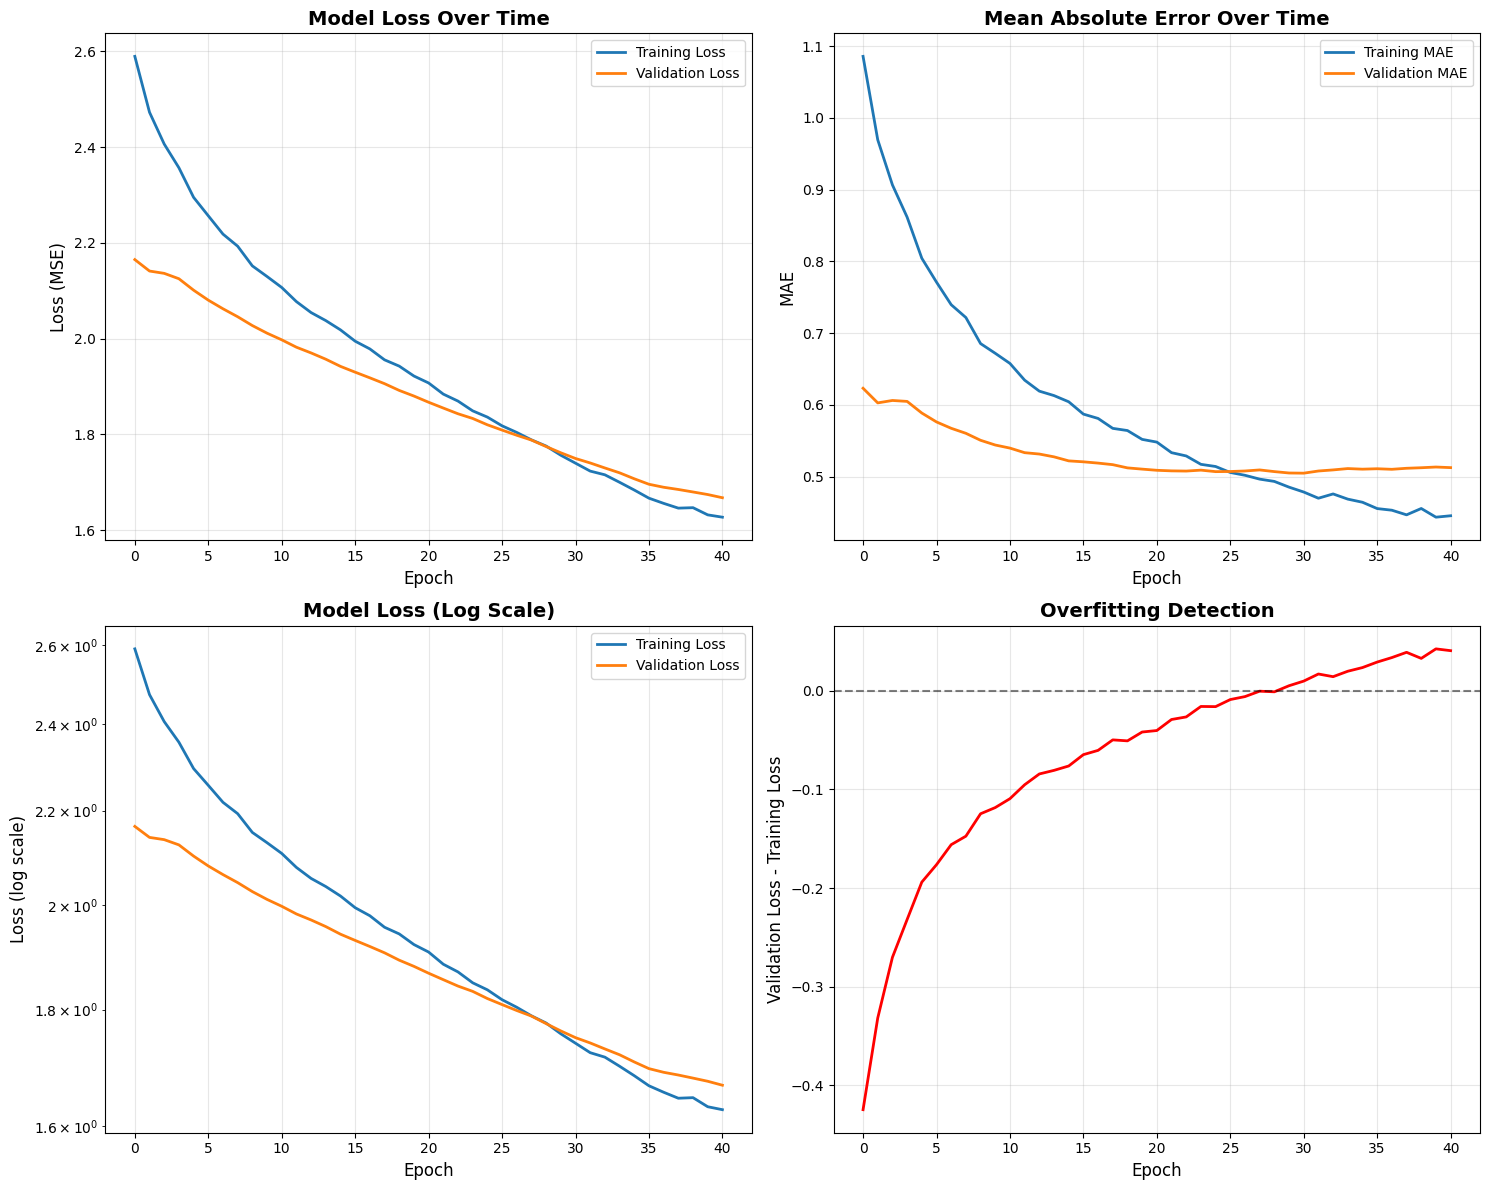


2. Predictions Analysis...


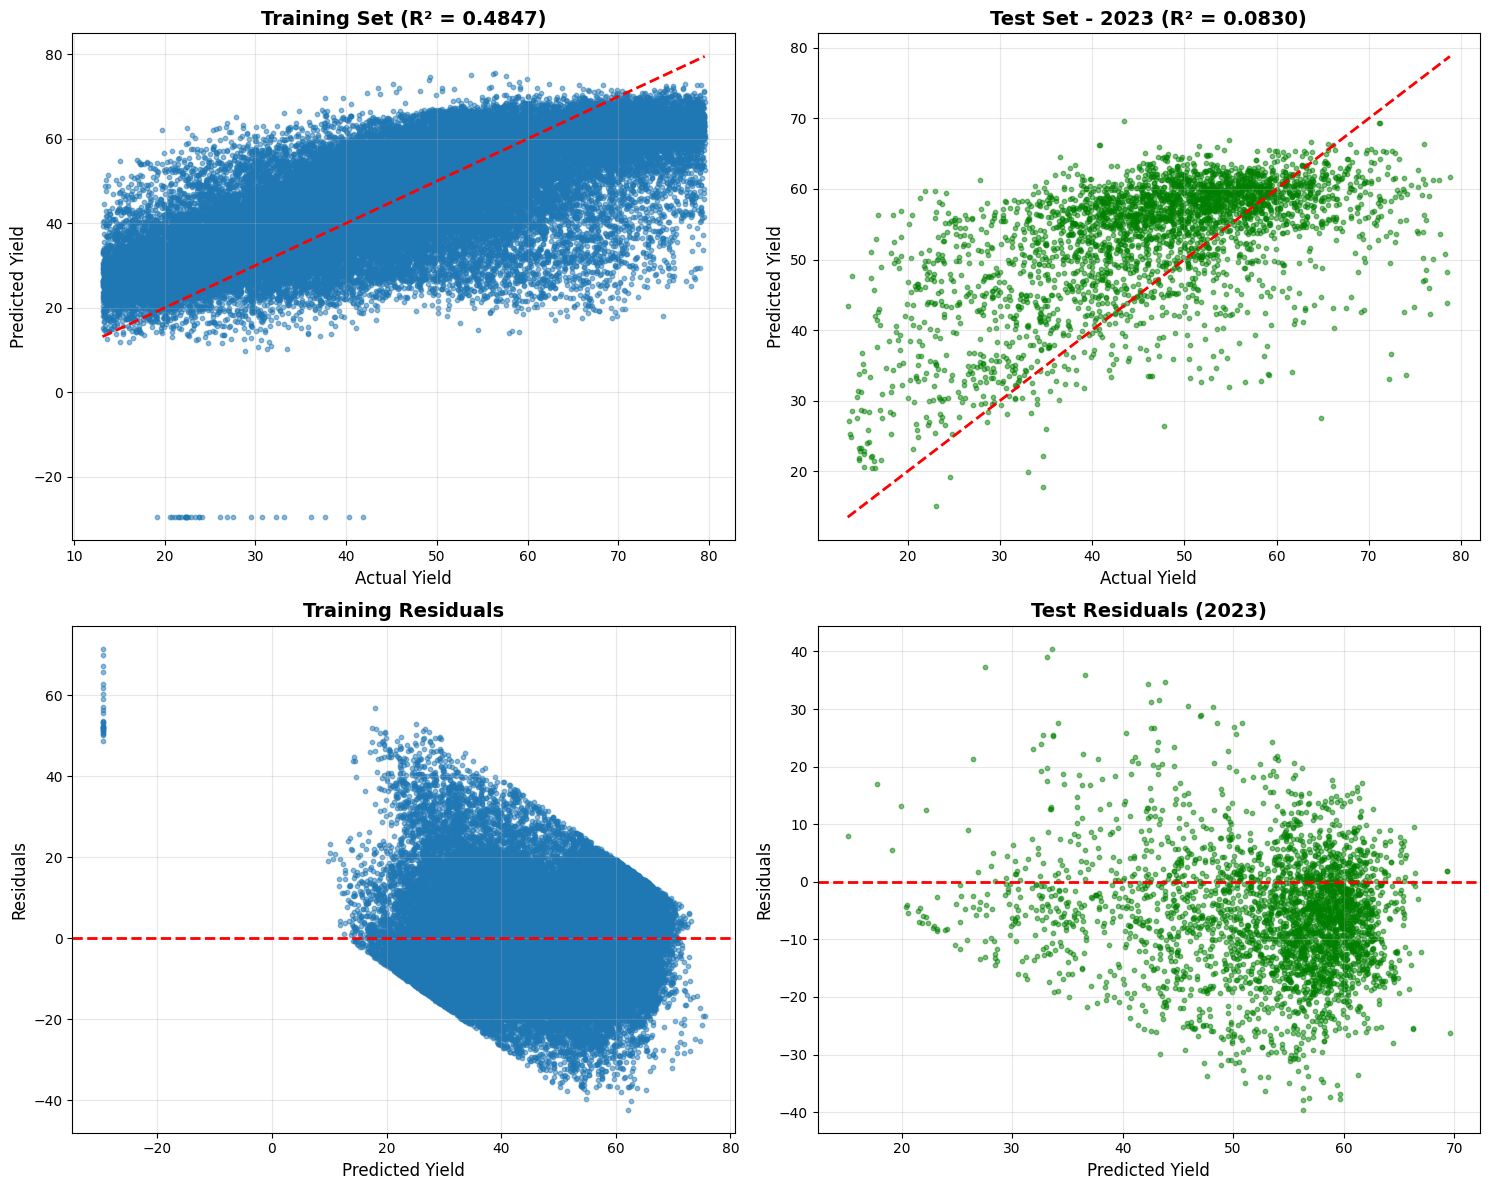


3. Error Distribution...


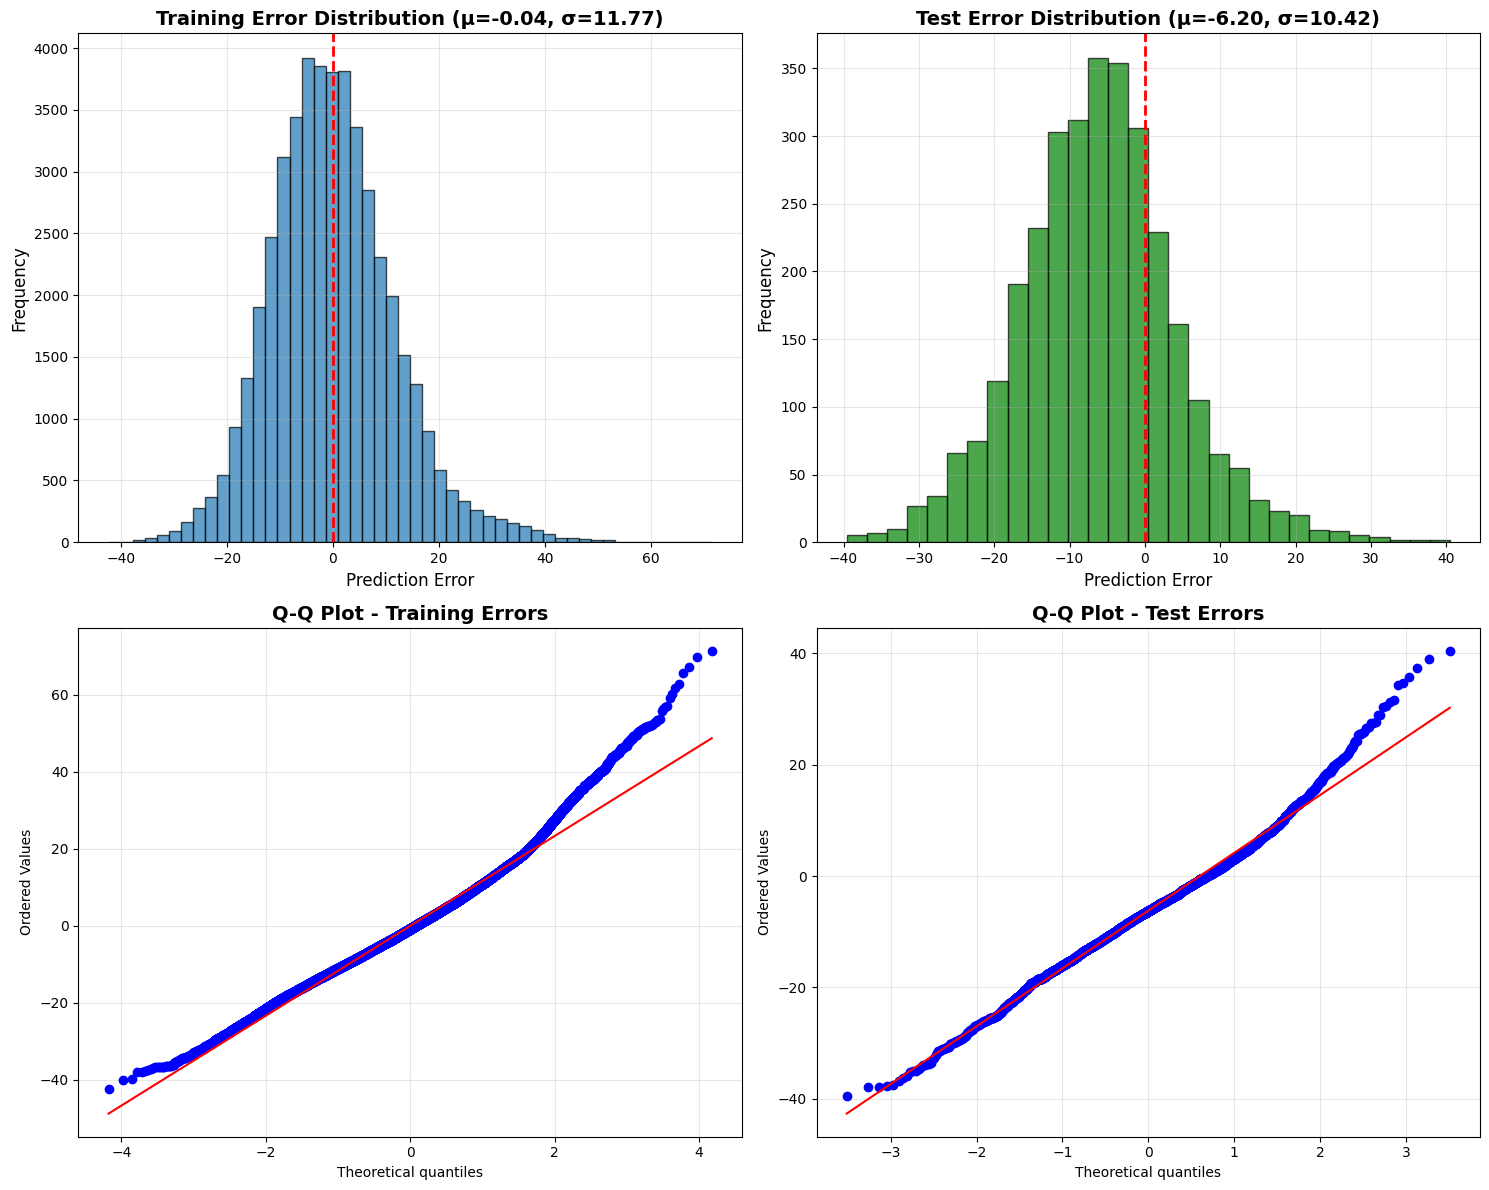


4. Metrics Comparison...


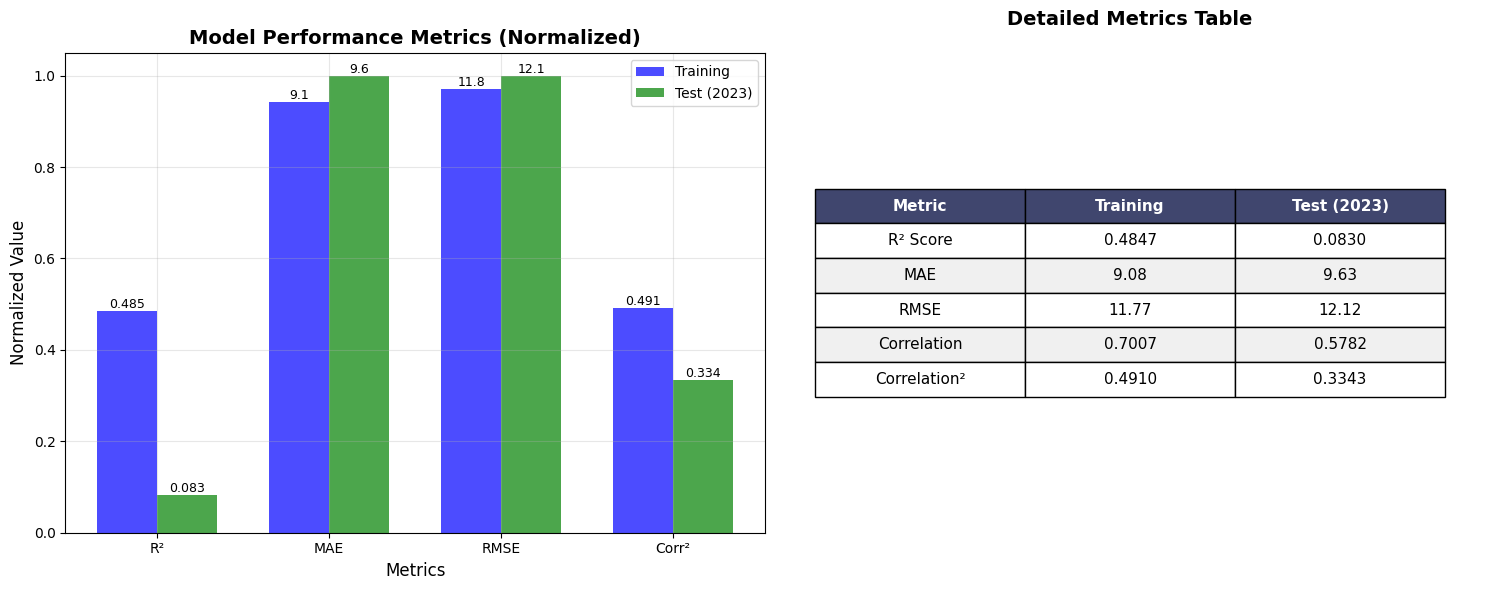


ANALYZING FEATURE IMPORTANCE...


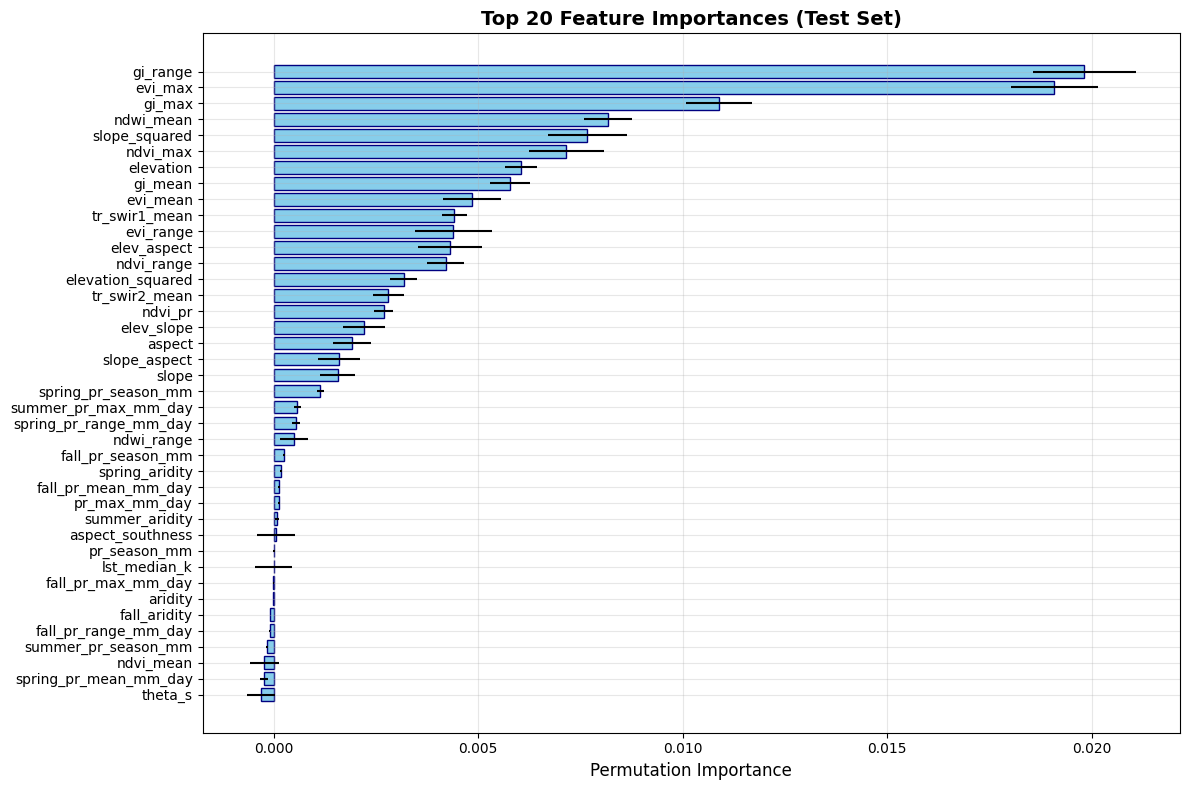


SAVING MODEL...
Model saved as 'final_soybean_yield_model.h5'
Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'

ANALYSIS COMPLETE!


In [54]:
def train_ensemble_models(X_train, y_train, X_test, y_test, n_models=5):
    """
    Train multiple models with different initializations for ensemble
    """
    print("\n" + "="*60)
    print("TRAINING ENSEMBLE MODELS...")
    print("="*60)

    models = []
    predictions_train = []
    predictions_test = []

    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models}...")

        # Set different random seed for each model
        tf.random.set_seed(42 + i)
        np.random.seed(42 + i)

        # Create model with slight variations
        model = create_model(
            input_dim=X_train.shape[1],
            hidden_layers=best_params['hidden_layers'],
            dropout_rate=best_params['dropout_rate'] + np.random.uniform(-0.05, 0.05),
            l1_reg=best_params['l1_reg'],
            l2_reg=best_params['l2_reg'],
            learning_rate=best_params['learning_rate'] * np.random.uniform(0.8, 1.2),
            activation=best_params['activation']
        )

        # Train with different data split
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=0.15, random_state=42+i
        )

        history, _ = train_model(
            model, X_train_split, y_train_split,
            X_val_split, y_val_split,
            best_params, model_name=f'ensemble_model_{i}'
        )

        models.append(model)
        predictions_train.append(model.predict(X_train, verbose=0).ravel())
        predictions_test.append(model.predict(X_test, verbose=0).ravel())

    # Ensemble predictions (average)
    ensemble_train_pred = np.mean(predictions_train, axis=0)
    ensemble_test_pred = np.mean(predictions_test, axis=0)

    # Calculate ensemble metrics
    ensemble_train_r2 = r2_score(y_train, ensemble_train_pred)
    ensemble_test_r2 = r2_score(y_test, ensemble_test_pred)

    print("\n" + "="*60)
    print("ENSEMBLE RESULTS:")
    print(f"  Training R²: {ensemble_train_r2:.4f}")
    print(f"  Test R² ({TEST_YEAR}): {ensemble_test_r2:.4f}")
    print("="*60)

    return models, ensemble_train_pred, ensemble_test_pred

# Run the main function
if __name__ == "__main__":
    # Assuming df_soybeans is already loaded in your environment
    # If not, uncomment and modify the following line:
    # df_soybeans = pd.read_csv('your_soybean_data.csv')

    model, metrics, history = main()

    # Optional: Train ensemble for potentially better performance
    # Note: This will take longer but might improve results
    # Uncomment the following lines if you want to try ensemble approach:

    # print("\n" + "="*60)
    # print("OPTIONAL: ENSEMBLE APPROACH")
    # print("="*60)
    # response = input("Do you want to train an ensemble of models? (y/n): ")
    # if response.lower() == 'y':
    #     # Prepare data again for ensemble
    #     (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
    #      scaler_X, scaler_y, _, _, _, _) = prepare_data(df_soybeans, available_features)
    #
    #     ensemble_models, ensemble_train_pred, ensemble_test_pred = train_ensemble_models(
    #         X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
    #     )

### Main

In [24]:

def main():
    """
    Main execution function
    """
    print("="*60)
    print("DEEP NEURAL NETWORK FOR SOYBEAN YIELD PREDICTION")
    print("="*60)

    # Define feature columns (update these based on your actual features)
    #feature_columns = [
              #       "evi_max",
              # "ndwi_max",
              # "gi_range",
              # "gi_mean",
              # "ndvi_max",
              # "evi_range",
              # "ndwi_mean",
              # "spring_aridity",
              # "lst_range_k",
              # "tr_swir2_mean"]


    feature_columns = [
        'ndvi_mean', 'ndvi_max',
          'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
          'pr_season_mm', 'pr_max_mm_day', 'pr_range_mm_day',
          'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
          'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
          'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
          'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
          'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
          'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
          'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
          'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
          'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
          'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
          'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
          'summer_pr_range_mm_day', 'summer_pr_season_mm'
    ]


    # Filter to only include features that exist in your dataframe
    available_features = [col for col in feature_columns if col in df_soybeans.columns]
    print(f"\nUsing {len(available_features)} features: {available_features}")

    # Prepare data
    print("\n" + "="*60)
    print("PREPARING DATA...")
    print("="*60)

    (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
     scaler_X, scaler_y, X_train, y_train, X_test, y_test) = prepare_data(
        df_soybeans, available_features
    )

    # Split training data for validation
    # X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    #     X_train_scaled, y_train_scaled, test_size=0.15, random_state=42
    # )

    # print(f"Training set: {X_train_split.shape}")
    # print(f"Validation set: {X_val_split.shape}")
    # print(f"Test set (2023): {X_test_scaled.shape}")


    # ============================================================
    # TEMPORAL VALIDATION SPLIT (instead of random split)
    # ============================================================
    print("\n" + "="*60)
    print("CREATING TEMPORAL VALIDATION SPLIT...")
    print("="*60)

    # Get the original training data (before {TEST_YEAR}) with year column
    train_data = df_soybeans[df_soybeans['year'] != TEST_YEAR].copy()

    # Check available years
    available_years = sorted(train_data['year'].unique())
    print(f"Available years in training data: {available_years}")

    # Define validation year(s) - USE LAST YEAR(S) BEFORE test_year
    # Option 1: Single year validation (recommended if limited data)
    # val_years = [2022]  # ← ADJUST THIS based on your data

    # Option 2: Multi-year validation (if you have many years of data)
    val_years = VAL_YEARS # ← Uncomment and use if preferred

    print(f"Using year(s) {val_years} as validation set")

    # Create temporal masks
    val_mask = train_data['year'].isin(val_years)
    train_mask = ~val_mask

    # Get indices for each split
    val_indices = train_data[val_mask].index
    train_indices = train_data[train_mask].index

    # Map to positions in scaled arrays
    val_positions = [i for i, idx in enumerate(train_data.index) if idx in val_indices]
    train_positions = [i for i, idx in enumerate(train_data.index) if idx in train_indices]

    # Split the scaled data
    X_train_split = X_train_scaled[train_positions]
    X_val_split = X_train_scaled[val_positions]
    y_train_split = y_train_scaled[train_positions]
    y_val_split = y_train_scaled[val_positions]

    # Print split information
    print(f"\nTemporal Split Summary:")
    print(f"Training set: {X_train_split.shape[0]} samples")
    print(f"  Years: {sorted(train_data[train_mask]['year'].unique())}")
    print(f"Validation set: {X_val_split.shape[0]} samples")
    print(f"  Years: {sorted(train_data[val_mask]['year'].unique())}")
    print(f"Test set ({TEST_YEAR}): {X_test_scaled.shape[0]} samples")

    # Show year distribution
    print(f"\nTraining year distribution:")
    print(train_data[train_mask]['year'].value_counts().sort_index())
    print(f"\nValidation year distribution:")
    print(train_data[val_mask]['year'].value_counts().sort_index())

    # Create and train model
    print("\n" + "="*60)
    print("BUILDING AND TRAINING MODEL...")
    print("="*60)

    model = create_model(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=best_params['hidden_layers'],
        dropout_rate=best_params['dropout_rate'],
        l1_reg=best_params['l1_reg'],
        l2_reg=best_params['l2_reg'],
        learning_rate=best_params['learning_rate'],
        activation=best_params['activation']
    )

    print("\nModel Architecture:")
    model.summary()

    print("\nTraining with parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    # Train the model
    history, lc_callback = train_model(
        model, X_train_split, y_train_split,
        X_val_split, y_val_split,
        best_params, model_name='soybean_yield_dnn'
    )

    # Evaluate model
    print("\n" + "="*60)
    print("EVALUATING MODEL...")
    print("="*60)

    metrics, y_train_pred, y_test_pred, y_train_orig, y_test_orig = evaluate_model(
        model, X_train_scaled, y_train_scaled,
        X_test_scaled, y_test_scaled, scaler_y
    )

    # Print metrics
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    print("\nTraining Set Performance:")
    print(f"  R² Score: {metrics['train_r2']:.4f}")
    print(f"  MAE: {metrics['train_mae']:.2f}")
    print(f"  RMSE: {metrics['train_rmse']:.2f}")
    print(f"  Correlation: {metrics['train_corr']:.4f}")
    print(f"  Correlation²: {metrics['train_corr_squared']:.4f}")

    print(f"\nTest Set Performance ({TEST_YEAR} Data):")
    print(f"  R² Score: {metrics['test_r2']:.4f}")
    print(f"  MAE: {metrics['test_mae']:.2f}")
    print(f"  RMSE: {metrics['test_rmse']:.2f}")
    print(f"  Correlation: {metrics['test_corr']:.4f}")
    print(f"  Correlation²: {metrics['test_corr_squared']:.4f}")

    # Generate all visualizations
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS...")
    print("="*60)

    print("\n1. Learning Curves...")
    plot_learning_curves(history, lc_callback)

    print("\n2. Predictions Analysis...")
    plot_predictions(y_train_orig, y_train_pred, y_test_orig, y_test_pred, metrics)

    print("\n3. Error Distribution...")
    plot_error_distribution(y_train_orig, y_train_pred, y_test_orig, y_test_pred)

    print("\n4. Metrics Comparison...")
    plot_metrics_comparison(metrics)

    # Feature importance using permutation
    print("\n" + "="*60)
    print("ANALYZING FEATURE IMPORTANCE...")
    print("="*60)

    try:
        from sklearn.inspection import permutation_importance

        # Create a wrapper class for sklearn compatibility
        class KerasRegressor:
            def __init__(self, model):
                self.model = model

            def fit(self, X, y):
                # Already fitted, just return self
                return self

            def predict(self, X):
                return self.model.predict(X, verbose=0).ravel()

            def score(self, X, y):
                y_pred = self.predict(X)
                return r2_score(y, y_pred)

        # Wrap the Keras model
        sklearn_compatible_model = KerasRegressor(model)

        # Calculate permutation importance on test set
        perm_importance = permutation_importance(
            sklearn_compatible_model, X_test_scaled, y_test_scaled,
            n_repeats=10, random_state=42, n_jobs=-1,
            scoring='neg_mean_squared_error'
        )

        # Create feature importance plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get top 20 features
        indices = np.argsort(perm_importance.importances_mean)[-40:]
        top_features = [available_features[i] for i in indices]
        importances = perm_importance.importances_mean[indices]
        std = perm_importance.importances_std[indices]

        ax.barh(range(len(indices)), importances, xerr=std, color='skyblue', edgecolor='navy')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Permutation Importance', fontsize=12)
        ax.set_title('Top 20 Feature Importances (Test Set)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Permutation importance failed: {e}")
        print("Using alternative feature importance method...")

        # Alternative: Calculate feature importance using gradient-based method
        import tensorflow as tf

        @tf.function
        def compute_gradients(X):
            X = tf.constant(X, dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(X)
                predictions = model(X, training=False)
            return tape.gradient(predictions, X)

        # Compute gradients for test set
        gradients = compute_gradients(X_test_scaled[:1000])  # Use subset for speed

        # Calculate mean absolute gradients as importance
        feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get top 20 features
        indices = np.argsort(feature_importance)[-40:]
        top_features = [available_features[i] for i in indices]
        importances = feature_importance[indices]

        ax.barh(range(len(indices)), importances, color='lightcoral', edgecolor='darkred')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Gradient-based Feature Importance', fontsize=12)
        ax.set_title('Top 20 Feature Importances (Test Set)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Save the model
    print("\n" + "="*60)
    print("SAVING MODEL...")
    print("="*60)
    model.save('final_soybean_yield_model.h5')
    print("Model saved as 'final_soybean_yield_model.h5'")

    # Save scalers for future use
    import joblib
    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')
    print("Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

    return model, metrics, history


## Run

DEEP NEURAL NETWORK FOR SOYBEAN YIELD PREDICTION

Using 53 features: ['ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k', 'pr_season_mm', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope', 'aspect', 'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day', 'spring_pr_mean_mm_day', 'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day', 'summer_pr_mean_mm_day', 'summer_pr_range_mm_day', 'summer_pr_season_mm']

PREPARING DATA...
Dataset shape: (50075, 60)
Training data

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 512)            │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,033 (797.00 KB)

 Trainable params: 202,113 (789.50 KB)

 Non-trainable params: 1,920 (7.50 KB)


Training with parameters:
  hidden_layers: [512, 256, 128, 64]
  dropout_rate: 0.35
  l1_reg: 0.0
  l2_reg: 0.001
  learning_rate: 0.0001
  batch_size: 2048
  epochs: 500
  activation: relu
Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 2.5303 - mae: 1.0279 - mse: 1.9371

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - loss: 2.5281 - mae: 1.0256 - mse: 1.9334 - val_loss: 2.1845 - val_mae: 0.6625 - val_mse: 0.6148 - learning_rate: 1.0000e-04
Epoch 2/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4022 - mae: 0.8963 - mse: 1.5458 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3902 - mae: 0.8833 - mse: 1.5562 - val_loss: 2.1182 - val_mae: 0.5977 - val_mse: 0.4927 - learning_rate: 1.0000e-04
Epoch 3/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3285 - mae: 0.8228 - mse: 1.7243 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3179 - mae: 0.8127 - mse: 1.6192 - val_loss: 2.0878 - val_mae: 0.5711 - val_mse: 0.4563 - learning_rate: 1.0000e-04
Epoch 4/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2649 - mae: 0.7652 - mse: 1.2271 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2604 - mae: 0.7612 - mse: 1.2033 - val_loss: 2.0687 - val_mae: 0.5552 - val_mse: 0.4444 - learning_rate: 1.0000e-04
Epoch 5/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2263 - mae: 0.7323 - mse: 1.1310 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2212 - mae: 0.7280 - mse: 1.1463 - val_loss: 2.0583 - val_mae: 0.5521 - val_mse: 0.4508 - learning_rate: 1.0000e-04
Epoch 6/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1873 - mae: 0.7007 - mse: 0.9188 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1806 - mae: 0.6944 - mse: 0.9192 - val_loss: 2.0485 - val_mae: 0.5518 - val_mse: 0.4579 - learning_rate: 1.0000e-04
Epoch 7/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1455 - mae: 0.6638 - mse: 0.9405 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1449 - mae: 0.6651 - mse: 0.9516 - val_loss: 2.0396 - val_mae: 0.5545 - val_mse: 0.4663 - learning_rate: 1.0000e-04
Epoch 8/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1356 - mae: 0.6666 - mse: 0.9290 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1274 - mae: 0.6582 - mse: 0.9381 - val_loss: 2.0262 - val_mae: 0.5520 - val_mse: 0.4646 - learning_rate: 1.0000e-04
Epoch 9/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0924 - mae: 0.6312 - mse: 0.7909 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0887 - mae: 0.6278 - mse: 0.7803 - val_loss: 2.0120 - val_mae: 0.5494 - val_mse: 0.4614 - learning_rate: 1.0000e-04
Epoch 10/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0797 - mae: 0.6267 - mse: 0.8176 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0725 - mae: 0.6195 - mse: 0.8154 - val_loss: 1.9984 - val_mae: 0.5470 - val_mse: 0.4598 - learning_rate: 1.0000e-04
Epoch 11/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0381 - mae: 0.5915 - mse: 0.6888 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0372 - mae: 0.5922 - mse: 0.6982 - val_loss: 1.9860 - val_mae: 0.5464 - val_mse: 0.4609 - learning_rate: 1.0000e-04
Epoch 12/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0217 - mae: 0.5859 - mse: 0.7087 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0179 - mae: 0.5827 - mse: 0.7279 - val_loss: 1.9733 - val_mae: 0.5455 - val_mse: 0.4614 - learning_rate: 1.0000e-04
Epoch 13/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9912 - mae: 0.5627 - mse: 0.5980 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9918 - mae: 0.5658 - mse: 0.6273 - val_loss: 1.9589 - val_mae: 0.5425 - val_mse: 0.4581 - learning_rate: 1.0000e-04
Epoch 14/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9728 - mae: 0.5547 - mse: 0.6351 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9707 - mae: 0.5545 - mse: 0.6256 - val_loss: 1.9478 - val_mae: 0.5436 - val_mse: 0.4626 - learning_rate: 1.0000e-04
Epoch 15/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9552 - mae: 0.5489 - mse: 0.5945 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9535 - mae: 0.5488 - mse: 0.5970 - val_loss: 1.9394 - val_mae: 0.5487 - val_mse: 0.4728 - learning_rate: 1.0000e-04
Epoch 16/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9472 - mae: 0.5556 - mse: 0.6747 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9418 - mae: 0.5508 - mse: 0.6464 - val_loss: 1.9277 - val_mae: 0.5495 - val_mse: 0.4757 - learning_rate: 1.0000e-04
Epoch 17/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9154 - mae: 0.5309 - mse: 0.5240 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9141 - mae: 0.5307 - mse: 0.5528 - val_loss: 1.9129 - val_mae: 0.5467 - val_mse: 0.4713 - learning_rate: 1.0000e-04
Epoch 18/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9003 - mae: 0.5266 - mse: 0.5772 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8988 - mae: 0.5263 - mse: 0.5926 - val_loss: 1.8982 - val_mae: 0.5440 - val_mse: 0.4674 - learning_rate: 1.0000e-04
Epoch 19/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8798 - mae: 0.5160 - mse: 0.5617 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8795 - mae: 0.5173 - mse: 0.6067 - val_loss: 1.8840 - val_mae: 0.5419 - val_mse: 0.4643 - learning_rate: 1.0000e-04
Epoch 20/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8690 - mae: 0.5173 - mse: 0.8779 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8675 - mae: 0.5172 - mse: 0.8096 - val_loss: 1.8708 - val_mae: 0.5412 - val_mse: 0.4638 - learning_rate: 1.0000e-04
Epoch 21/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8409 - mae: 0.4985 - mse: 0.4821 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8413 - mae: 0.5003 - mse: 0.5345 - val_loss: 1.8562 - val_mae: 0.5390 - val_mse: 0.4598 - learning_rate: 1.0000e-04
Epoch 22/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8346 - mae: 0.5048 - mse: 0.7524 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8309 - mae: 0.5022 - mse: 0.6784 - val_loss: 1.8446 - val_mae: 0.5400 - val_mse: 0.4626 - learning_rate: 1.0000e-04
Epoch 23/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8135 - mae: 0.4962 - mse: 0.4601 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8111 - mae: 0.4943 - mse: 0.4770 - val_loss: 1.8310 - val_mae: 0.5385 - val_mse: 0.4612 - learning_rate: 1.0000e-04
Epoch 24/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7919 - mae: 0.4809 - mse: 0.5389 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7913 - mae: 0.4826 - mse: 0.5364 - val_loss: 1.8193 - val_mae: 0.5403 - val_mse: 0.4639 - learning_rate: 1.0000e-04
Epoch 25/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7736 - mae: 0.4748 - mse: 0.4834 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7734 - mae: 0.4765 - mse: 0.4874 - val_loss: 1.8038 - val_mae: 0.5365 - val_mse: 0.4581 - learning_rate: 1.0000e-04
Epoch 26/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7559 - mae: 0.4686 - mse: 0.4502 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7552 - mae: 0.4693 - mse: 0.4542 - val_loss: 1.7897 - val_mae: 0.5351 - val_mse: 0.4552 - learning_rate: 1.0000e-04
Epoch 27/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7495 - mae: 0.4773 - mse: 0.5058 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7467 - mae: 0.4752 - mse: 0.5070 - val_loss: 1.7785 - val_mae: 0.5368 - val_mse: 0.4589 - learning_rate: 1.0000e-04
Epoch 28/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7305 - mae: 0.4687 - mse: 0.4612 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7290 - mae: 0.4677 - mse: 0.4852 - val_loss: 1.7649 - val_mae: 0.5360 - val_mse: 0.4570 - learning_rate: 1.0000e-04
Epoch 29/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7101 - mae: 0.4575 - mse: 0.4106 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7098 - mae: 0.4580 - mse: 0.4499 - val_loss: 1.7501 - val_mae: 0.5328 - val_mse: 0.4528 - learning_rate: 1.0000e-04
Epoch 30/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7028 - mae: 0.4638 - mse: 0.4982 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7003 - mae: 0.4623 - mse: 0.4936 - val_loss: 1.7358 - val_mae: 0.5307 - val_mse: 0.4493 - learning_rate: 1.0000e-04
Epoch 31/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6777 - mae: 0.4474 - mse: 0.4341 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6780 - mae: 0.4490 - mse: 0.4579 - val_loss: 1.7235 - val_mae: 0.5304 - val_mse: 0.4506 - learning_rate: 1.0000e-04
Epoch 32/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6700 - mae: 0.4524 - mse: 0.4365 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6678 - mae: 0.4513 - mse: 0.4466 - val_loss: 1.7099 - val_mae: 0.5291 - val_mse: 0.4488 - learning_rate: 1.0000e-04
Epoch 33/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6541 - mae: 0.4474 - mse: 0.4748 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6527 - mae: 0.4473 - mse: 0.4725 - val_loss: 1.6957 - val_mae: 0.5272 - val_mse: 0.4454 - learning_rate: 1.0000e-04
Epoch 34/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6299 - mae: 0.4326 - mse: 0.3509 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6298 - mae: 0.4341 - mse: 0.3708 - val_loss: 1.6808 - val_mae: 0.5239 - val_mse: 0.4406 - learning_rate: 1.0000e-04
Epoch 35/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6246 - mae: 0.4394 - mse: 0.4770 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6216 - mae: 0.4376 - mse: 0.4519 - val_loss: 1.6671 - val_mae: 0.5231 - val_mse: 0.4382 - learning_rate: 1.0000e-04
Epoch 36/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6042 - mae: 0.4307 - mse: 0.3753 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6028 - mae: 0.4308 - mse: 0.3898 - val_loss: 1.6542 - val_mae: 0.5225 - val_mse: 0.4377 - learning_rate: 1.0000e-04
Epoch 37/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5862 - mae: 0.4224 - mse: 0.3558 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5855 - mae: 0.4235 - mse: 0.3640 - val_loss: 1.6436 - val_mae: 0.5244 - val_mse: 0.4426 - learning_rate: 1.0000e-04
Epoch 38/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5798 - mae: 0.4283 - mse: 0.6262 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5775 - mae: 0.4274 - mse: 0.5592 - val_loss: 1.6308 - val_mae: 0.5243 - val_mse: 0.4419 - learning_rate: 1.0000e-04
Epoch 39/500
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5629 - mae: 0.4249 - mse: 0.4195 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5616 - mae: 0.4248 - mse: 0.4271 - val_loss: 1.6182 - val_mae: 0.5250 - val_mse: 0.4414 - learning_rate: 1.0000e-04
Epoch 40/500
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5505 - mae: 0.4243 - mse: 0.3743 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5497 - mae: 0.4251 - mse: 0.3959 - val_loss: 1.6040 - val_mae: 0.5232 - val_mse: 0.4376 - learning_rate: 1.0000e-04
Epoch 41/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5359 - mae: 0.4216 - mse: 0.3837 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5346 - mae: 0.4219 - mse: 0.3880 - val_loss: 1.5908 - val_mae: 0.5221 - val_mse: 0.4361 - learning_rate: 1.0000e-04
Epoch 42/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5205 - mae: 0.4153 - mse: 0.4182 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5186 - mae: 0.4153 - mse: 0.4023 - val_loss: 1.5769 - val_mae: 0.5204 - val_mse: 0.4326 - learning_rate: 1.0000e-04
Epoch 43/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5049 - mae: 0.4106 - mse: 0.3486 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5036 - mae: 0.4109 - mse: 0.3683 - val_loss: 1.5625 - val_mae: 0.5175 - val_mse: 0.4284 - learning_rate: 1.0000e-04
Epoch 44/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4933 - mae: 0.4124 - mse: 0.3830 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4915 - mae: 0.4121 - mse: 0.3852 - val_loss: 1.5504 - val_mae: 0.5178 - val_mse: 0.4289 - learning_rate: 1.0000e-04
Epoch 45/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4759 - mae: 0.4075 - mse: 0.3078 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4749 - mae: 0.4070 - mse: 0.3286 - val_loss: 1.5405 - val_mae: 0.5208 - val_mse: 0.4344 - learning_rate: 1.0000e-04
Epoch 46/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4602 - mae: 0.3997 - mse: 0.3469 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4602 - mae: 0.4011 - mse: 0.3674 - val_loss: 1.5293 - val_mae: 0.5223 - val_mse: 0.4369 - learning_rate: 1.0000e-04
Epoch 47/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4499 - mae: 0.4035 - mse: 0.3376 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4493 - mae: 0.4042 - mse: 0.3689 - val_loss: 1.5148 - val_mae: 0.5200 - val_mse: 0.4317 - learning_rate: 1.0000e-04
Epoch 48/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4383 - mae: 0.4046 - mse: 0.4014 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4363 - mae: 0.4033 - mse: 0.3961 - val_loss: 1.5017 - val_mae: 0.5187 - val_mse: 0.4298 - learning_rate: 1.0000e-04
Epoch 49/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4236 - mae: 0.3992 - mse: 0.3687 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4214 - mae: 0.3983 - mse: 0.3544 - val_loss: 1.4899 - val_mae: 0.5188 - val_mse: 0.4308 - learning_rate: 1.0000e-04
Epoch 50/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4073 - mae: 0.3923 - mse: 0.3717 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4084 - mae: 0.3955 - mse: 0.4025 - val_loss: 1.4759 - val_mae: 0.5165 - val_mse: 0.4264 - learning_rate: 1.0000e-04
Epoch 51/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3984 - mae: 0.3985 - mse: 0.4031 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3961 - mae: 0.3972 - mse: 0.3759 - val_loss: 1.4637 - val_mae: 0.5169 - val_mse: 0.4261 - learning_rate: 1.0000e-04
Epoch 52/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3837 - mae: 0.3939 - mse: 0.4229 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3826 - mae: 0.3945 - mse: 0.4060 - val_loss: 1.4523 - val_mae: 0.5176 - val_mse: 0.4278 - learning_rate: 1.0000e-04
Epoch 53/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3633 - mae: 0.3804 - mse: 0.2860 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3642 - mae: 0.3839 - mse: 0.3108 - val_loss: 1.4405 - val_mae: 0.5173 - val_mse: 0.4284 - learning_rate: 1.0000e-04
Epoch 54/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3553 - mae: 0.3872 - mse: 0.3424 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3547 - mae: 0.3882 - mse: 0.3501 - val_loss: 1.4273 - val_mae: 0.5155 - val_mse: 0.4257 - learning_rate: 1.0000e-04
Epoch 55/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3446 - mae: 0.3863 - mse: 0.4435 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3431 - mae: 0.3859 - mse: 0.4344 - val_loss: 1.4147 - val_mae: 0.5142 - val_mse: 0.4244 - learning_rate: 1.0000e-04
Epoch 56/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3318 - mae: 0.3862 - mse: 0.3855 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3299 - mae: 0.3855 - mse: 0.3732 - val_loss: 1.4026 - val_mae: 0.5139 - val_mse: 0.4241 - learning_rate: 1.0000e-04
Epoch 57/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3196 - mae: 0.3846 - mse: 0.3728 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3188 - mae: 0.3851 - mse: 0.3903 - val_loss: 1.3903 - val_mae: 0.5144 - val_mse: 0.4226 - learning_rate: 1.0000e-04
Epoch 58/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3024 - mae: 0.3750 - mse: 0.3894 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3023 - mae: 0.3773 - mse: 0.3954 - val_loss: 1.3787 - val_mae: 0.5145 - val_mse: 0.4231 - learning_rate: 1.0000e-04
Epoch 59/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2928 - mae: 0.3803 - mse: 0.3529 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2914 - mae: 0.3803 - mse: 0.3477 - val_loss: 1.3663 - val_mae: 0.5134 - val_mse: 0.4216 - learning_rate: 1.0000e-04
Epoch 60/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2818 - mae: 0.3796 - mse: 0.5296 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2801 - mae: 0.3797 - mse: 0.4710 - val_loss: 1.3556 - val_mae: 0.5143 - val_mse: 0.4239 - learning_rate: 1.0000e-04
Epoch 61/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2680 - mae: 0.3786 - mse: 0.3614 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2659 - mae: 0.3776 - mse: 0.3420 - val_loss: 1.3455 - val_mae: 0.5167 - val_mse: 0.4272 - learning_rate: 1.0000e-04
Epoch 62/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2556 - mae: 0.3753 - mse: 0.3568 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2545 - mae: 0.3754 - mse: 0.3709 - val_loss: 1.3339 - val_mae: 0.5163 - val_mse: 0.4273 - learning_rate: 1.0000e-04
Epoch 63/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2388 - mae: 0.3671 - mse: 0.3639 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2384 - mae: 0.3690 - mse: 0.3515 - val_loss: 1.3208 - val_mae: 0.5138 - val_mse: 0.4240 - learning_rate: 1.0000e-04
Epoch 64/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2256 - mae: 0.3665 - mse: 0.2753 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2249 - mae: 0.3675 - mse: 0.2817 - val_loss: 1.3075 - val_mae: 0.5119 - val_mse: 0.4196 - learning_rate: 1.0000e-04
Epoch 65/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2148 - mae: 0.3670 - mse: 0.3186 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2144 - mae: 0.3684 - mse: 0.3257 - val_loss: 1.2985 - val_mae: 0.5151 - val_mse: 0.4251 - learning_rate: 1.0000e-04
Epoch 66/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2044 - mae: 0.3674 - mse: 0.3675 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2031 - mae: 0.3677 - mse: 0.3534 - val_loss: 1.2862 - val_mae: 0.5142 - val_mse: 0.4228 - learning_rate: 1.0000e-04
Epoch 67/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1939 - mae: 0.3693 - mse: 0.4738 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1918 - mae: 0.3684 - mse: 0.4266 - val_loss: 1.2772 - val_mae: 0.5169 - val_mse: 0.4282 - learning_rate: 1.0000e-04
Epoch 68/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1805 - mae: 0.3645 - mse: 0.3324 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1797 - mae: 0.3651 - mse: 0.3418 - val_loss: 1.2675 - val_mae: 0.5185 - val_mse: 0.4317 - learning_rate: 1.0000e-04
Epoch 69/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1702 - mae: 0.3662 - mse: 0.4785 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1687 - mae: 0.3658 - mse: 0.4358 - val_loss: 1.2549 - val_mae: 0.5170 - val_mse: 0.4287 - learning_rate: 1.0000e-04
Epoch 70/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1564 - mae: 0.3637 - mse: 0.2548 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1553 - mae: 0.3640 - mse: 0.2692 - val_loss: 1.2416 - val_mae: 0.5145 - val_mse: 0.4235 - learning_rate: 1.0000e-04
Epoch 71/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1409 - mae: 0.3576 - mse: 0.2903 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1409 - mae: 0.3591 - mse: 0.3002 - val_loss: 1.2321 - val_mae: 0.5158 - val_mse: 0.4273 - learning_rate: 1.0000e-04
Epoch 72/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1342 - mae: 0.3625 - mse: 0.3240 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1324 - mae: 0.3619 - mse: 0.3091 - val_loss: 1.2207 - val_mae: 0.5154 - val_mse: 0.4264 - learning_rate: 1.0000e-04
Epoch 73/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1221 - mae: 0.3607 - mse: 0.3458 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1209 - mae: 0.3608 - mse: 0.3391 - val_loss: 1.2093 - val_mae: 0.5156 - val_mse: 0.4252 - learning_rate: 1.0000e-04
Epoch 74/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1079 - mae: 0.3558 - mse: 0.3119 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1078 - mae: 0.3572 - mse: 0.3162 - val_loss: 1.1991 - val_mae: 0.5162 - val_mse: 0.4268 - learning_rate: 1.0000e-04
Epoch 75/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0944 - mae: 0.3512 - mse: 0.2957 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0940 - mae: 0.3524 - mse: 0.2890 - val_loss: 1.1882 - val_mae: 0.5157 - val_mse: 0.4270 - learning_rate: 1.0000e-04
Epoch 76/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0869 - mae: 0.3568 - mse: 0.3118 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0856 - mae: 0.3565 - mse: 0.3130 - val_loss: 1.1771 - val_mae: 0.5151 - val_mse: 0.4262 - learning_rate: 1.0000e-04
Epoch 77/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0753 - mae: 0.3533 - mse: 0.3051 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0739 - mae: 0.3531 - mse: 0.3093 - val_loss: 1.1665 - val_mae: 0.5151 - val_mse: 0.4266 - learning_rate: 1.0000e-04
Epoch 78/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0654 - mae: 0.3547 - mse: 0.4006 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0635 - mae: 0.3538 - mse: 0.3622 - val_loss: 1.1563 - val_mae: 0.5157 - val_mse: 0.4275 - learning_rate: 1.0000e-04
Epoch 79/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0499 - mae: 0.3480 - mse: 0.3400 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0504 - mae: 0.3501 - mse: 0.3541 - val_loss: 1.1470 - val_mae: 0.5172 - val_mse: 0.4305 - learning_rate: 1.0000e-04
Epoch 80/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0369 - mae: 0.3442 - mse: 0.2616 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0376 - mae: 0.3472 - mse: 0.2864 - val_loss: 1.1354 - val_mae: 0.5155 - val_mse: 0.4282 - learning_rate: 1.0000e-04
Epoch 81/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0381 - mae: 0.3605 - mse: 0.4801 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0344 - mae: 0.3572 - mse: 0.4215 - val_loss: 1.1232 - val_mae: 0.5137 - val_mse: 0.4242 - learning_rate: 1.0000e-04
Epoch 82/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0168 - mae: 0.3443 - mse: 0.2962 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0169 - mae: 0.3466 - mse: 0.3021 - val_loss: 1.1109 - val_mae: 0.5118 - val_mse: 0.4197 - learning_rate: 1.0000e-04
Epoch 83/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0060 - mae: 0.3456 - mse: 0.2914 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0060 - mae: 0.3469 - mse: 0.2977 - val_loss: 1.1009 - val_mae: 0.5121 - val_mse: 0.4206 - learning_rate: 1.0000e-04
Epoch 84/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9926 - mae: 0.3427 - mse: 0.2243 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9923 - mae: 0.3435 - mse: 0.2290 - val_loss: 1.0906 - val_mae: 0.5120 - val_mse: 0.4207 - learning_rate: 1.0000e-04
Epoch 85/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9921 - mae: 0.3516 - mse: 0.4514 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9892 - mae: 0.3498 - mse: 0.4116 - val_loss: 1.0794 - val_mae: 0.5107 - val_mse: 0.4183 - learning_rate: 1.0000e-04
Epoch 86/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9785 - mae: 0.3475 - mse: 0.4112 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9773 - mae: 0.3475 - mse: 0.4000 - val_loss: 1.0690 - val_mae: 0.5105 - val_mse: 0.4178 - learning_rate: 1.0000e-04
Epoch 87/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9644 - mae: 0.3422 - mse: 0.3057 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9634 - mae: 0.3429 - mse: 0.2927 - val_loss: 1.0593 - val_mae: 0.5111 - val_mse: 0.4186 - learning_rate: 1.0000e-04
Epoch 88/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9485 - mae: 0.3328 - mse: 0.2483 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9491 - mae: 0.3356 - mse: 0.2589 - val_loss: 1.0495 - val_mae: 0.5114 - val_mse: 0.4191 - learning_rate: 1.0000e-04
Epoch 89/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9428 - mae: 0.3401 - mse: 0.2473 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9425 - mae: 0.3412 - mse: 0.2671 - val_loss: 1.0408 - val_mae: 0.5135 - val_mse: 0.4215 - learning_rate: 1.0000e-04
Epoch 90/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9301 - mae: 0.3359 - mse: 0.2403 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9298 - mae: 0.3367 - mse: 0.2549 - val_loss: 1.0309 - val_mae: 0.5133 - val_mse: 0.4217 - learning_rate: 1.0000e-04
Epoch 91/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9198 - mae: 0.3367 - mse: 0.2238 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9206 - mae: 0.3387 - mse: 0.2563 - val_loss: 1.0221 - val_mae: 0.5144 - val_mse: 0.4238 - learning_rate: 1.0000e-04
Epoch 92/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9089 - mae: 0.3339 - mse: 0.2240 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9084 - mae: 0.3344 - mse: 0.2315 - val_loss: 1.0122 - val_mae: 0.5147 - val_mse: 0.4234 - learning_rate: 1.0000e-04
Epoch 93/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9027 - mae: 0.3356 - mse: 0.3027 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9020 - mae: 0.3365 - mse: 0.3062 - val_loss: 1.0015 - val_mae: 0.5128 - val_mse: 0.4213 - learning_rate: 1.0000e-04
Epoch 94/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8910 - mae: 0.3344 - mse: 0.2358 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8907 - mae: 0.3355 - mse: 0.2583 - val_loss: 0.9915 - val_mae: 0.5126 - val_mse: 0.4203 - learning_rate: 1.0000e-04
Epoch 95/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8797 - mae: 0.3312 - mse: 0.2543 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8798 - mae: 0.3328 - mse: 0.2751 - val_loss: 0.9825 - val_mae: 0.5132 - val_mse: 0.4214 - learning_rate: 1.0000e-04
Epoch 96/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8684 - mae: 0.3305 - mse: 0.2091 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8685 - mae: 0.3317 - mse: 0.2190 - val_loss: 0.9733 - val_mae: 0.5137 - val_mse: 0.4220 - learning_rate: 1.0000e-04
Epoch 97/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8589 - mae: 0.3287 - mse: 0.2190 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8585 - mae: 0.3296 - mse: 0.2272 - val_loss: 0.9638 - val_mae: 0.5136 - val_mse: 0.4218 - learning_rate: 1.0000e-04
Epoch 98/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8493 - mae: 0.3293 - mse: 0.2302 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8498 - mae: 0.3313 - mse: 0.2526 - val_loss: 0.9540 - val_mae: 0.5133 - val_mse: 0.4206 - learning_rate: 1.0000e-04
Epoch 99/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8411 - mae: 0.3292 - mse: 0.2410 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8403 - mae: 0.3299 - mse: 0.2408 - val_loss: 0.9438 - val_mae: 0.5129 - val_mse: 0.4182 - learning_rate: 1.0000e-04
Epoch 100/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8311 - mae: 0.3275 - mse: 0.2996 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8309 - mae: 0.3293 - mse: 0.2884 - val_loss: 0.9358 - val_mae: 0.5137 - val_mse: 0.4213 - learning_rate: 1.0000e-04
Epoch 101/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8211 - mae: 0.3248 - mse: 0.2706 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8219 - mae: 0.3277 - mse: 0.2929 - val_loss: 0.9281 - val_mae: 0.5155 - val_mse: 0.4243 - learning_rate: 1.0000e-04
Epoch 102/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8127 - mae: 0.3278 - mse: 0.3047 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8126 - mae: 0.3288 - mse: 0.3032 - val_loss: 0.9195 - val_mae: 0.5158 - val_mse: 0.4256 - learning_rate: 1.0000e-04
Epoch 103/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8067 - mae: 0.3298 - mse: 0.3223 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8058 - mae: 0.3308 - mse: 0.3078 - val_loss: 0.9088 - val_mae: 0.5147 - val_mse: 0.4211 - learning_rate: 1.0000e-04
Epoch 104/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7958 - mae: 0.3291 - mse: 0.3022 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7951 - mae: 0.3298 - mse: 0.2880 - val_loss: 0.9006 - val_mae: 0.5150 - val_mse: 0.4230 - learning_rate: 1.0000e-04
Epoch 105/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7809 - mae: 0.3203 - mse: 0.2099 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7813 - mae: 0.3221 - mse: 0.2265 - val_loss: 0.8928 - val_mae: 0.5161 - val_mse: 0.4253 - learning_rate: 1.0000e-04
Epoch 106/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7744 - mae: 0.3232 - mse: 0.2512 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7744 - mae: 0.3244 - mse: 0.2585 - val_loss: 0.8855 - val_mae: 0.5179 - val_mse: 0.4286 - learning_rate: 1.0000e-04
Epoch 107/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7660 - mae: 0.3226 - mse: 0.2550 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7655 - mae: 0.3236 - mse: 0.2521 - val_loss: 0.8771 - val_mae: 0.5191 - val_mse: 0.4290 - learning_rate: 1.0000e-04
Epoch 108/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7584 - mae: 0.3216 - mse: 0.3978 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7578 - mae: 0.3231 - mse: 0.3538 - val_loss: 0.8690 - val_mae: 0.5203 - val_mse: 0.4300 - learning_rate: 1.0000e-04
Epoch 109/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7471 - mae: 0.3204 - mse: 0.2442 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7472 - mae: 0.3217 - mse: 0.2554 - val_loss: 0.8587 - val_mae: 0.5178 - val_mse: 0.4262 - learning_rate: 1.0000e-04
Epoch 110/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7387 - mae: 0.3195 - mse: 0.2945 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7382 - mae: 0.3205 - mse: 0.2841 - val_loss: 0.8497 - val_mae: 0.5175 - val_mse: 0.4249 - learning_rate: 1.0000e-04
Epoch 111/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7288 - mae: 0.3160 - mse: 0.2614 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7288 - mae: 0.3183 - mse: 0.2543 - val_loss: 0.8412 - val_mae: 0.5184 - val_mse: 0.4242 - learning_rate: 1.0000e-04
Epoch 112/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7217 - mae: 0.3177 - mse: 0.3120 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7208 - mae: 0.3188 - mse: 0.2843 - val_loss: 0.8325 - val_mae: 0.5186 - val_mse: 0.4232 - learning_rate: 1.0000e-04
Epoch 113/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7077 - mae: 0.3129 - mse: 0.2041 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7093 - mae: 0.3157 - mse: 0.2487 - val_loss: 0.8247 - val_mae: 0.5189 - val_mse: 0.4244 - learning_rate: 1.0000e-04
Epoch 114/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7056 - mae: 0.3189 - mse: 0.3768 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7043 - mae: 0.3190 - mse: 0.3366 - val_loss: 0.8172 - val_mae: 0.5195 - val_mse: 0.4261 - learning_rate: 1.0000e-04
Epoch 115/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6974 - mae: 0.3184 - mse: 0.2970 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6975 - mae: 0.3203 - mse: 0.3068 - val_loss: 0.8102 - val_mae: 0.5204 - val_mse: 0.4289 - learning_rate: 1.0000e-04
Epoch 116/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6839 - mae: 0.3120 - mse: 0.2037 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6845 - mae: 0.3137 - mse: 0.2253 - val_loss: 0.8024 - val_mae: 0.5216 - val_mse: 0.4292 - learning_rate: 1.0000e-04
Epoch 117/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6764 - mae: 0.3115 - mse: 0.2603 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6764 - mae: 0.3132 - mse: 0.2591 - val_loss: 0.7939 - val_mae: 0.5214 - val_mse: 0.4278 - learning_rate: 1.0000e-04
Epoch 118/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6698 - mae: 0.3138 - mse: 0.2786 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6693 - mae: 0.3142 - mse: 0.2669 - val_loss: 0.7861 - val_mae: 0.5215 - val_mse: 0.4278 - learning_rate: 1.0000e-04
Epoch 119/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6612 - mae: 0.3100 - mse: 0.2691 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6614 - mae: 0.3122 - mse: 0.2788 - val_loss: 0.7790 - val_mae: 0.5223 - val_mse: 0.4297 - learning_rate: 1.0000e-04
Epoch 120/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6512 - mae: 0.3092 - mse: 0.1948 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6514 - mae: 0.3108 - mse: 0.2087 - val_loss: 0.7695 - val_mae: 0.5209 - val_mse: 0.4254 - learning_rate: 1.0000e-04
Epoch 121/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6428 - mae: 0.3081 - mse: 0.2179 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6433 - mae: 0.3101 - mse: 0.2347 - val_loss: 0.7619 - val_mae: 0.5211 - val_mse: 0.4257 - learning_rate: 1.0000e-04
Epoch 122/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6366 - mae: 0.3092 - mse: 0.2380 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6374 - mae: 0.3115 - mse: 0.2600 - val_loss: 0.7568 - val_mae: 0.5236 - val_mse: 0.4315 - learning_rate: 1.0000e-04
Epoch 123/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6251 - mae: 0.3061 - mse: 0.1776 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6260 - mae: 0.3080 - mse: 0.1971 - val_loss: 0.7510 - val_mae: 0.5260 - val_mse: 0.4354 - learning_rate: 1.0000e-04
Epoch 124/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6212 - mae: 0.3087 - mse: 0.2515 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6210 - mae: 0.3098 - mse: 0.2522 - val_loss: 0.7427 - val_mae: 0.5250 - val_mse: 0.4336 - learning_rate: 1.0000e-04
Epoch 125/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6143 - mae: 0.3100 - mse: 0.2327 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6135 - mae: 0.3100 - mse: 0.2329 - val_loss: 0.7338 - val_mae: 0.5240 - val_mse: 0.4298 - learning_rate: 1.0000e-04
Epoch 126/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6030 - mae: 0.3051 - mse: 0.1799 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6029 - mae: 0.3064 - mse: 0.1874 - val_loss: 0.7265 - val_mae: 0.5247 - val_mse: 0.4299 - learning_rate: 1.0000e-04
Epoch 127/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5985 - mae: 0.3084 - mse: 0.2625 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5981 - mae: 0.3089 - mse: 0.2616 - val_loss: 0.7208 - val_mae: 0.5257 - val_mse: 0.4336 - learning_rate: 1.0000e-04
Epoch 128/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5901 - mae: 0.3044 - mse: 0.3069 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5899 - mae: 0.3059 - mse: 0.2797 - val_loss: 0.7158 - val_mae: 0.5293 - val_mse: 0.4383 - learning_rate: 1.0000e-04
Epoch 129/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5811 - mae: 0.3035 - mse: 0.2139 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5823 - mae: 0.3063 - mse: 0.2353 - val_loss: 0.7062 - val_mae: 0.5266 - val_mse: 0.4326 - learning_rate: 1.0000e-04
Epoch 130/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5735 - mae: 0.3025 - mse: 0.2107 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5737 - mae: 0.3036 - mse: 0.2186 - val_loss: 0.7000 - val_mae: 0.5271 - val_mse: 0.4348 - learning_rate: 1.0000e-04
Epoch 131/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5679 - mae: 0.3025 - mse: 0.3066 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5672 - mae: 0.3031 - mse: 0.2753 - val_loss: 0.6937 - val_mae: 0.5287 - val_mse: 0.4360 - learning_rate: 1.0000e-04
Epoch 132/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5602 - mae: 0.3028 - mse: 0.2371 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5600 - mae: 0.3035 - mse: 0.2356 - val_loss: 0.6885 - val_mae: 0.5306 - val_mse: 0.4398 - learning_rate: 1.0000e-04
Epoch 133/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5523 - mae: 0.3018 - mse: 0.1910 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5522 - mae: 0.3027 - mse: 0.2028 - val_loss: 0.6811 - val_mae: 0.5304 - val_mse: 0.4382 - learning_rate: 1.0000e-04
Epoch 134/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5464 - mae: 0.3013 - mse: 0.2634 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5460 - mae: 0.3025 - mse: 0.2526 - val_loss: 0.6739 - val_mae: 0.5297 - val_mse: 0.4373 - learning_rate: 1.0000e-04
Epoch 135/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5358 - mae: 0.2981 - mse: 0.1623 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5361 - mae: 0.2992 - mse: 0.1717 - val_loss: 0.6675 - val_mae: 0.5299 - val_mse: 0.4381 - learning_rate: 1.0000e-04
Epoch 136/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5316 - mae: 0.2989 - mse: 0.2135 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5316 - mae: 0.3001 - mse: 0.2170 - val_loss: 0.6604 - val_mae: 0.5304 - val_mse: 0.4367 - learning_rate: 1.0000e-04
Epoch 137/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5249 - mae: 0.3002 - mse: 0.2061 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5246 - mae: 0.3007 - mse: 0.2123 - val_loss: 0.6546 - val_mae: 0.5320 - val_mse: 0.4381 - learning_rate: 1.0000e-04
Epoch 138/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5173 - mae: 0.2963 - mse: 0.3108 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5172 - mae: 0.2978 - mse: 0.2904 - val_loss: 0.6492 - val_mae: 0.5335 - val_mse: 0.4406 - learning_rate: 1.0000e-04
Epoch 139/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5119 - mae: 0.2980 - mse: 0.2885 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5125 - mae: 0.3003 - mse: 0.2937 - val_loss: 0.6434 - val_mae: 0.5335 - val_mse: 0.4421 - learning_rate: 1.0000e-04
Epoch 140/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5033 - mae: 0.2975 - mse: 0.1711 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5027 - mae: 0.2973 - mse: 0.1786 - val_loss: 0.6352 - val_mae: 0.5318 - val_mse: 0.4377 - learning_rate: 1.0000e-04
Epoch 141/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4951 - mae: 0.2937 - mse: 0.1922 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4961 - mae: 0.2960 - mse: 0.2080 - val_loss: 0.6292 - val_mae: 0.5320 - val_mse: 0.4384 - learning_rate: 1.0000e-04
Epoch 142/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4918 - mae: 0.2963 - mse: 0.2060 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4915 - mae: 0.2969 - mse: 0.2152 - val_loss: 0.6212 - val_mae: 0.5304 - val_mse: 0.4342 - learning_rate: 1.0000e-04
Epoch 143/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4834 - mae: 0.2940 - mse: 0.2190 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4839 - mae: 0.2955 - mse: 0.2312 - val_loss: 0.6162 - val_mae: 0.5321 - val_mse: 0.4368 - learning_rate: 1.0000e-04
Epoch 144/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4750 - mae: 0.2912 - mse: 0.1723 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4758 - mae: 0.2931 - mse: 0.1848 - val_loss: 0.6101 - val_mae: 0.5324 - val_mse: 0.4368 - learning_rate: 1.0000e-04
Epoch 145/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4711 - mae: 0.2930 - mse: 0.2148 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4712 - mae: 0.2944 - mse: 0.2201 - val_loss: 0.6056 - val_mae: 0.5341 - val_mse: 0.4402 - learning_rate: 1.0000e-04
Epoch 146/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4659 - mae: 0.2929 - mse: 0.3165 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4658 - mae: 0.2938 - mse: 0.3042 - val_loss: 0.5990 - val_mae: 0.5340 - val_mse: 0.4383 - learning_rate: 1.0000e-04
Epoch 147/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4598 - mae: 0.2926 - mse: 0.2321 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4595 - mae: 0.2934 - mse: 0.2280 - val_loss: 0.5958 - val_mae: 0.5364 - val_mse: 0.4446 - learning_rate: 1.0000e-04
Epoch 148/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4540 - mae: 0.2931 - mse: 0.2246 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4536 - mae: 0.2937 - mse: 0.2269 - val_loss: 0.5877 - val_mae: 0.5355 - val_mse: 0.4390 - learning_rate: 1.0000e-04
Epoch 149/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4473 - mae: 0.2917 - mse: 0.2217 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4469 - mae: 0.2924 - mse: 0.2144 - val_loss: 0.5837 - val_mae: 0.5368 - val_mse: 0.4430 - learning_rate: 1.0000e-04
Epoch 150/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4408 - mae: 0.2903 - mse: 0.2299 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4413 - mae: 0.2919 - mse: 0.2370 - val_loss: 0.5763 - val_mae: 0.5346 - val_mse: 0.4392 - learning_rate: 1.0000e-04
Epoch 151/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4365 - mae: 0.2927 - mse: 0.2160 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4367 - mae: 0.2936 - mse: 0.2274 - val_loss: 0.5732 - val_mae: 0.5376 - val_mse: 0.4447 - learning_rate: 1.0000e-04
Epoch 152/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4277 - mae: 0.2856 - mse: 0.1960 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4283 - mae: 0.2876 - mse: 0.2077 - val_loss: 0.5673 - val_mae: 0.5374 - val_mse: 0.4439 - learning_rate: 1.0000e-04
Epoch 153/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4258 - mae: 0.2913 - mse: 0.3002 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4253 - mae: 0.2915 - mse: 0.2917 - val_loss: 0.5624 - val_mae: 0.5380 - val_mse: 0.4452 - learning_rate: 1.0000e-04
Epoch 154/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4147 - mae: 0.2808 - mse: 0.1781 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4151 - mae: 0.2830 - mse: 0.1805 - val_loss: 0.5572 - val_mae: 0.5387 - val_mse: 0.4455 - learning_rate: 1.0000e-04
Epoch 155/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4122 - mae: 0.2880 - mse: 0.2320 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4129 - mae: 0.2896 - mse: 0.2452 - val_loss: 0.5517 - val_mae: 0.5394 - val_mse: 0.4447 - learning_rate: 1.0000e-04
Epoch 156/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4073 - mae: 0.2868 - mse: 0.2437 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4070 - mae: 0.2877 - mse: 0.2312 - val_loss: 0.5456 - val_mae: 0.5384 - val_mse: 0.4430 - learning_rate: 1.0000e-04
Epoch 157/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3999 - mae: 0.2848 - mse: 0.1906 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4001 - mae: 0.2862 - mse: 0.1925 - val_loss: 0.5399 - val_mae: 0.5379 - val_mse: 0.4419 - learning_rate: 1.0000e-04
Epoch 158/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3934 - mae: 0.2833 - mse: 0.1796 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3938 - mae: 0.2847 - mse: 0.1872 - val_loss: 0.5359 - val_mae: 0.5389 - val_mse: 0.4443 - learning_rate: 1.0000e-04
Epoch 159/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3912 - mae: 0.2863 - mse: 0.2573 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3909 - mae: 0.2870 - mse: 0.2465 - val_loss: 0.5318 - val_mae: 0.5401 - val_mse: 0.4466 - learning_rate: 1.0000e-04
Epoch 160/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3849 - mae: 0.2842 - mse: 0.2313 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3852 - mae: 0.2854 - mse: 0.2351 - val_loss: 0.5284 - val_mae: 0.5423 - val_mse: 0.4499 - learning_rate: 1.0000e-04
Epoch 161/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3802 - mae: 0.2834 - mse: 0.2617 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3802 - mae: 0.2845 - mse: 0.2532 - val_loss: 0.5235 - val_mae: 0.5425 - val_mse: 0.4502 - learning_rate: 1.0000e-04
Epoch 162/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3714 - mae: 0.2779 - mse: 0.1712 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3720 - mae: 0.2800 - mse: 0.1789 - val_loss: 0.5191 - val_mae: 0.5434 - val_mse: 0.4509 - learning_rate: 1.0000e-04
Epoch 163/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3687 - mae: 0.2815 - mse: 0.2097 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3682 - mae: 0.2817 - mse: 0.2007 - val_loss: 0.5141 - val_mae: 0.5430 - val_mse: 0.4506 - learning_rate: 1.0000e-04
Epoch 164/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3639 - mae: 0.2828 - mse: 0.2030 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3645 - mae: 0.2843 - mse: 0.2095 - val_loss: 0.5085 - val_mae: 0.5424 - val_mse: 0.4485 - learning_rate: 1.0000e-04
Epoch 165/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3631 - mae: 0.2840 - mse: 0.3930 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3620 - mae: 0.2842 - mse: 0.3359 - val_loss: 0.5040 - val_mae: 0.5422 - val_mse: 0.4492 - learning_rate: 1.0000e-04
Epoch 166/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3530 - mae: 0.2784 - mse: 0.2095 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3532 - mae: 0.2797 - mse: 0.2102 - val_loss: 0.4963 - val_mae: 0.5398 - val_mse: 0.4419 - learning_rate: 1.0000e-04
Epoch 167/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3482 - mae: 0.2799 - mse: 0.1904 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3480 - mae: 0.2805 - mse: 0.1823 - val_loss: 0.4946 - val_mae: 0.5426 - val_mse: 0.4486 - learning_rate: 1.0000e-04
Epoch 168/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3442 - mae: 0.2768 - mse: 0.2350 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3443 - mae: 0.2784 - mse: 0.2306 - val_loss: 0.4887 - val_mae: 0.5408 - val_mse: 0.4456 - learning_rate: 1.0000e-04
Epoch 169/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3400 - mae: 0.2786 - mse: 0.2248 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3397 - mae: 0.2792 - mse: 0.2233 - val_loss: 0.4844 - val_mae: 0.5411 - val_mse: 0.4460 - learning_rate: 1.0000e-04
Epoch 170/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3350 - mae: 0.2777 - mse: 0.2119 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3351 - mae: 0.2789 - mse: 0.2142 - val_loss: 0.4804 - val_mae: 0.5422 - val_mse: 0.4465 - learning_rate: 1.0000e-04
Epoch 171/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3293 - mae: 0.2776 - mse: 0.1824 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3292 - mae: 0.2783 - mse: 0.1849 - val_loss: 0.4776 - val_mae: 0.5436 - val_mse: 0.4500 - learning_rate: 1.0000e-04
Epoch 172/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3230 - mae: 0.2721 - mse: 0.1888 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3240 - mae: 0.2747 - mse: 0.1930 - val_loss: 0.4711 - val_mae: 0.5414 - val_mse: 0.4450 - learning_rate: 1.0000e-04
Epoch 173/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3192 - mae: 0.2732 - mse: 0.1721 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3202 - mae: 0.2756 - mse: 0.1835 - val_loss: 0.4668 - val_mae: 0.5413 - val_mse: 0.4447 - learning_rate: 1.0000e-04
Epoch 174/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3172 - mae: 0.2770 - mse: 0.2456 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3174 - mae: 0.2785 - mse: 0.2291 - val_loss: 0.4644 - val_mae: 0.5432 - val_mse: 0.4488 - learning_rate: 1.0000e-04
Epoch 175/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3110 - mae: 0.2713 - mse: 0.1885 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3119 - mae: 0.2738 - mse: 0.2014 - val_loss: 0.4613 - val_mae: 0.5459 - val_mse: 0.4507 - learning_rate: 1.0000e-04
Epoch 176/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3051 - mae: 0.2699 - mse: 0.1503 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3057 - mae: 0.2717 - mse: 0.1630 - val_loss: 0.4561 - val_mae: 0.5452 - val_mse: 0.4481 - learning_rate: 1.0000e-04
Epoch 177/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3008 - mae: 0.2717 - mse: 0.1353 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3014 - mae: 0.2732 - mse: 0.1461 - val_loss: 0.4513 - val_mae: 0.5438 - val_mse: 0.4465 - learning_rate: 1.0000e-04
Epoch 178/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2990 - mae: 0.2724 - mse: 0.2124 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2989 - mae: 0.2727 - mse: 0.2171 - val_loss: 0.4502 - val_mae: 0.5458 - val_mse: 0.4533 - learning_rate: 1.0000e-04
Epoch 179/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2953 - mae: 0.2730 - mse: 0.2091 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2948 - mae: 0.2728 - mse: 0.2010 - val_loss: 0.4425 - val_mae: 0.5415 - val_mse: 0.4448 - learning_rate: 1.0000e-04
Epoch 180/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2920 - mae: 0.2722 - mse: 0.2647 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2917 - mae: 0.2726 - mse: 0.2432 - val_loss: 0.4404 - val_mae: 0.5438 - val_mse: 0.4482 - learning_rate: 1.0000e-04
Epoch 181/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2864 - mae: 0.2684 - mse: 0.2131 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2871 - mae: 0.2706 - mse: 0.2139 - val_loss: 0.4381 - val_mae: 0.5463 - val_mse: 0.4513 - learning_rate: 1.0000e-04
Epoch 182/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2821 - mae: 0.2688 - mse: 0.1923 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2826 - mae: 0.2706 - mse: 0.1981 - val_loss: 0.4333 - val_mae: 0.5447 - val_mse: 0.4489 - learning_rate: 1.0000e-04
Epoch 183/500
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2770 - mae: 0.2659 - mse: 0.1624 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2775 - mae: 0.2675 - mse: 0.1703 - val_loss: 0.4281 - val_mae: 0.5422 - val_mse: 0.4458 - learning_rate: 1.0000e-04
Epoch 184/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2762 - mae: 0.2679 - mse: 0.2825 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2757 - mae: 0.2687 - mse: 0.2549 - val_loss: 0.4235 - val_mae: 0.5416 - val_mse: 0.4432 - learning_rate: 1.0000e-04
Epoch 185/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2760 - mae: 0.2744 - mse: 0.4127 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2750 - mae: 0.2740 - mse: 0.3484 - val_loss: 0.4193 - val_mae: 0.5408 - val_mse: 0.4416 - learning_rate: 1.0000e-04
Epoch 186/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2678 - mae: 0.2679 - mse: 0.2180 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2683 - mae: 0.2692 - mse: 0.2185 - val_loss: 0.4192 - val_mae: 0.5447 - val_mse: 0.4495 - learning_rate: 1.0000e-04
Epoch 187/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2623 - mae: 0.2651 - mse: 0.1673 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2634 - mae: 0.2671 - mse: 0.1886 - val_loss: 0.4175 - val_mae: 0.5478 - val_mse: 0.4528 - learning_rate: 1.0000e-04
Epoch 188/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2583 - mae: 0.2640 - mse: 0.1620 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2588 - mae: 0.2656 - mse: 0.1675 - val_loss: 0.4157 - val_mae: 0.5490 - val_mse: 0.4568 - learning_rate: 1.0000e-04
Epoch 189/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2544 - mae: 0.2633 - mse: 0.1577 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2550 - mae: 0.2647 - mse: 0.1673 - val_loss: 0.4102 - val_mae: 0.5478 - val_mse: 0.4512 - learning_rate: 1.0000e-04
Epoch 190/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2531 - mae: 0.2667 - mse: 0.1956 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2532 - mae: 0.2672 - mse: 0.1952 - val_loss: 0.4101 - val_mae: 0.5503 - val_mse: 0.4588 - learning_rate: 1.0000e-04
Epoch 191/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2500 - mae: 0.2660 - mse: 0.1903 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2503 - mae: 0.2667 - mse: 0.1965 - val_loss: 0.4036 - val_mae: 0.5475 - val_mse: 0.4512 - learning_rate: 1.0000e-04
Epoch 192/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2435 - mae: 0.2602 - mse: 0.1583 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2445 - mae: 0.2625 - mse: 0.1698 - val_loss: 0.4010 - val_mae: 0.5477 - val_mse: 0.4528 - learning_rate: 1.0000e-04
Epoch 193/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2409 - mae: 0.2622 - mse: 0.1401 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2412 - mae: 0.2629 - mse: 0.1503 - val_loss: 0.3973 - val_mae: 0.5478 - val_mse: 0.4511 - learning_rate: 1.0000e-04
Epoch 194/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2388 - mae: 0.2621 - mse: 0.1900 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2392 - mae: 0.2636 - mse: 0.1926 - val_loss: 0.3960 - val_mae: 0.5497 - val_mse: 0.4553 - learning_rate: 1.0000e-04
Epoch 195/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2332 - mae: 0.2574 - mse: 0.1806 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2331 - mae: 0.2583 - mse: 0.1694 - val_loss: 0.3914 - val_mae: 0.5483 - val_mse: 0.4517 - learning_rate: 1.0000e-04
Epoch 196/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2302 - mae: 0.2592 - mse: 0.1494 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2313 - mae: 0.2611 - mse: 0.1616 - val_loss: 0.3912 - val_mae: 0.5507 - val_mse: 0.4581 - learning_rate: 1.0000e-04
Epoch 197/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2284 - mae: 0.2585 - mse: 0.1721 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2286 - mae: 0.2597 - mse: 0.1741 - val_loss: 0.3864 - val_mae: 0.5496 - val_mse: 0.4537 - learning_rate: 1.0000e-04
Epoch 198/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2241 - mae: 0.2574 - mse: 0.1709 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2251 - mae: 0.2594 - mse: 0.1898 - val_loss: 0.3840 - val_mae: 0.5502 - val_mse: 0.4546 - learning_rate: 1.0000e-04
Epoch 199/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2208 - mae: 0.2565 - mse: 0.1523 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2221 - mae: 0.2589 - mse: 0.1673 - val_loss: 0.3831 - val_mae: 0.5522 - val_mse: 0.4594 - learning_rate: 1.0000e-04
Epoch 200/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2205 - mae: 0.2608 - mse: 0.1819 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2202 - mae: 0.2606 - mse: 0.1744 - val_loss: 0.3829 - val_mae: 0.5559 - val_mse: 0.4649 - learning_rate: 1.0000e-04
Epoch 201/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2141 - mae: 0.2555 - mse: 0.1359 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2149 - mae: 0.2571 - mse: 0.1421 - val_loss: 0.3807 - val_mae: 0.5570 - val_mse: 0.4659 - learning_rate: 1.0000e-04
Epoch 202/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2141 - mae: 0.2557 - mse: 0.2569 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2136 - mae: 0.2564 - mse: 0.2245 - val_loss: 0.3783 - val_mae: 0.5580 - val_mse: 0.4664 - learning_rate: 1.0000e-04
Epoch 203/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2109 - mae: 0.2567 - mse: 0.2025 - val_loss: 0.3799 - val_mae: 0.5629 - val_mse: 0.4763 - learning_rate: 1.0000e-04
Epoch 204/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2080 - mae: 0.2557 - mse: 0.1765 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2086 - mae: 0.2570 - mse: 0.1856 - val_loss: 0.3764 - val_mae: 0.5634 - val_mse: 0.4732 - learning_rate: 1.0000e-04
Epoch 205/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2039 - mae: 0.2543 - mse: 0.1527 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2040 - mae: 0.2550 - mse: 0.1556 - val_loss: 0.3760 - val_mae: 0.5649 - val_mse: 0.4787 - learning_rate: 1.0000e-04
Epoch 206/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2018 - mae: 0.2551 - mse: 0.1697 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2027 - mae: 0.2565 - mse: 0.1819 - val_loss: 0.3691 - val_mae: 0.5597 - val_mse: 0.4687 - learning_rate: 1.0000e-04
Epoch 207/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1974 - mae: 0.2520 - mse: 0.1407 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1983 - mae: 0.2536 - mse: 0.1554 - val_loss: 0.3667 - val_mae: 0.5599 - val_mse: 0.4689 - learning_rate: 1.0000e-04
Epoch 208/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1968 - mae: 0.2520 - mse: 0.1704 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1971 - mae: 0.2537 - mse: 0.1685 - val_loss: 0.3655 - val_mae: 0.5604 - val_mse: 0.4721 - learning_rate: 1.0000e-04
Epoch 209/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1930 - mae: 0.2509 - mse: 0.1441 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1941 - mae: 0.2532 - mse: 0.1634 - val_loss: 0.3636 - val_mae: 0.5612 - val_mse: 0.4729 - learning_rate: 1.0000e-04
Epoch 210/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1925 - mae: 0.2535 - mse: 0.2320 - val_loss: 0.3653 - val_mae: 0.5663 - val_mse: 0.4818 - learning_rate: 1.0000e-04
Epoch 211/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1863 - mae: 0.2492 - mse: 0.1461 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1874 - mae: 0.2509 - mse: 0.1613 - val_loss: 0.3626 - val_mae: 0.5660 - val_mse: 0.4809 - learning_rate: 1.0000e-04
Epoch 212/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1863 - mae: 0.2511 - mse: 0.1688 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1865 - mae: 0.2520 - mse: 0.1721 - val_loss: 0.3593 - val_mae: 0.5650 - val_mse: 0.4783 - learning_rate: 1.0000e-04
Epoch 213/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1845 - mae: 0.2515 - mse: 0.1761 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1855 - mae: 0.2531 - mse: 0.1933 - val_loss: 0.3566 - val_mae: 0.5632 - val_mse: 0.4781 - learning_rate: 1.0000e-04
Epoch 214/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1834 - mae: 0.2534 - mse: 0.2406 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1829 - mae: 0.2534 - mse: 0.2154 - val_loss: 0.3553 - val_mae: 0.5647 - val_mse: 0.4799 - learning_rate: 1.0000e-04
Epoch 215/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1786 - mae: 0.2498 - mse: 0.1513 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1794 - mae: 0.2512 - mse: 0.1655 - val_loss: 0.3525 - val_mae: 0.5648 - val_mse: 0.4784 - learning_rate: 1.0000e-04
Epoch 216/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1751 - mae: 0.2476 - mse: 0.1450 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1762 - mae: 0.2492 - mse: 0.1573 - val_loss: 0.3509 - val_mae: 0.5646 - val_mse: 0.4802 - learning_rate: 1.0000e-04
Epoch 217/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1767 - mae: 0.2508 - mse: 0.2161 - val_loss: 0.3533 - val_mae: 0.5695 - val_mse: 0.4901 - learning_rate: 1.0000e-04
Epoch 218/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1709 - mae: 0.2469 - mse: 0.1384 - val_loss: 0.3535 - val_mae: 0.5717 - val_mse: 0.4952 - learning_rate: 1.0000e-04
Epoch 219/500
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1719 - mae: 0.2482 - mse: 0.2751 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1715 - mae: 0.2491 - mse: 0.2502 - val_loss: 0.3501 - val_mae: 0.5700 - val_mse: 0.4921 - learning_rate: 1.0000e-04
Epoch 220/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1660 - mae: 0.2460 - mse: 0.1436 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1672 - mae: 0.2479 - mse: 0.1587 - val_loss: 0.3488 - val_mae: 0.5719 - val_mse: 0.4931 - learning_rate: 1.0000e-04
Epoch 221/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1673 - mae: 0.2483 - mse: 0.2175 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1667 - mae: 0.2487 - mse: 0.1917 - val_loss: 0.3446 - val_mae: 0.5684 - val_mse: 0.4886 - learning_rate: 1.0000e-04
Epoch 222/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1623 - mae: 0.2435 - mse: 0.1604 - val_loss: 0.3461 - val_mae: 0.5735 - val_mse: 0.4960 - learning_rate: 1.0000e-04
Epoch 223/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1595 - mae: 0.2444 - mse: 0.1288 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1603 - mae: 0.2455 - mse: 0.1367 - val_loss: 0.3437 - val_mae: 0.5719 - val_mse: 0.4947 - learning_rate: 1.0000e-04
Epoch 224/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1589 - mae: 0.2452 - mse: 0.1579 - val_loss: 0.3485 - val_mae: 0.5794 - val_mse: 0.5095 - learning_rate: 1.0000e-04
Epoch 225/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1558 - mae: 0.2427 - mse: 0.1340 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1566 - mae: 0.2443 - mse: 0.1413 - val_loss: 0.3435 - val_mae: 0.5769 - val_mse: 0.5021 - learning_rate: 1.0000e-04
Epoch 226/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1530 - mae: 0.2410 - mse: 0.1413 - val_loss: 0.3443 - val_mae: 0.5796 - val_mse: 0.5089 - learning_rate: 1.0000e-04
Epoch 227/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1519 - mae: 0.2417 - mse: 0.1357 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1521 - mae: 0.2426 - mse: 0.1358 - val_loss: 0.3411 - val_mae: 0.5796 - val_mse: 0.5053 - learning_rate: 1.0000e-04
Epoch 228/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1500 - mae: 0.2411 - mse: 0.1626 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1508 - mae: 0.2428 - mse: 0.1654 - val_loss: 0.3403 - val_mae: 0.5805 - val_mse: 0.5074 - learning_rate: 1.0000e-04
Epoch 229/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1499 - mae: 0.2429 - mse: 0.1690 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1500 - mae: 0.2436 - mse: 0.1703 - val_loss: 0.3362 - val_mae: 0.5777 - val_mse: 0.5014 - learning_rate: 1.0000e-04
Epoch 230/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1465 - mae: 0.2401 - mse: 0.1477 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1473 - mae: 0.2417 - mse: 0.1548 - val_loss: 0.3341 - val_mae: 0.5763 - val_mse: 0.5009 - learning_rate: 1.0000e-04
Epoch 231/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1470 - mae: 0.2429 - mse: 0.2046 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1466 - mae: 0.2431 - mse: 0.1876 - val_loss: 0.3316 - val_mae: 0.5756 - val_mse: 0.4989 - learning_rate: 1.0000e-04
Epoch 232/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1445 - mae: 0.2401 - mse: 0.1817 - val_loss: 0.3350 - val_mae: 0.5820 - val_mse: 0.5100 - learning_rate: 1.0000e-04
Epoch 233/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1411 - mae: 0.2394 - mse: 0.1396 - val_loss: 0.3342 - val_mae: 0.5828 - val_mse: 0.5120 - learning_rate: 1.0000e-04
Epoch 234/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1388 - mae: 0.2380 - mse: 0.1327 - val_loss: 0.3354 - val_mae: 0.5869 - val_mse: 0.5178 - learning_rate: 1.0000e-04
Epoch 235/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1371 - mae: 0.2379 - mse: 0.1250 - val_loss: 0.3344 - val_mae: 0.5870 - val_mse: 0.5190 - learning_rate: 1.0000e-04
Epoch 236/500
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1372 - mae: 0.2378 - mse: 0.1660 
Epoch 236: ReduceLROn

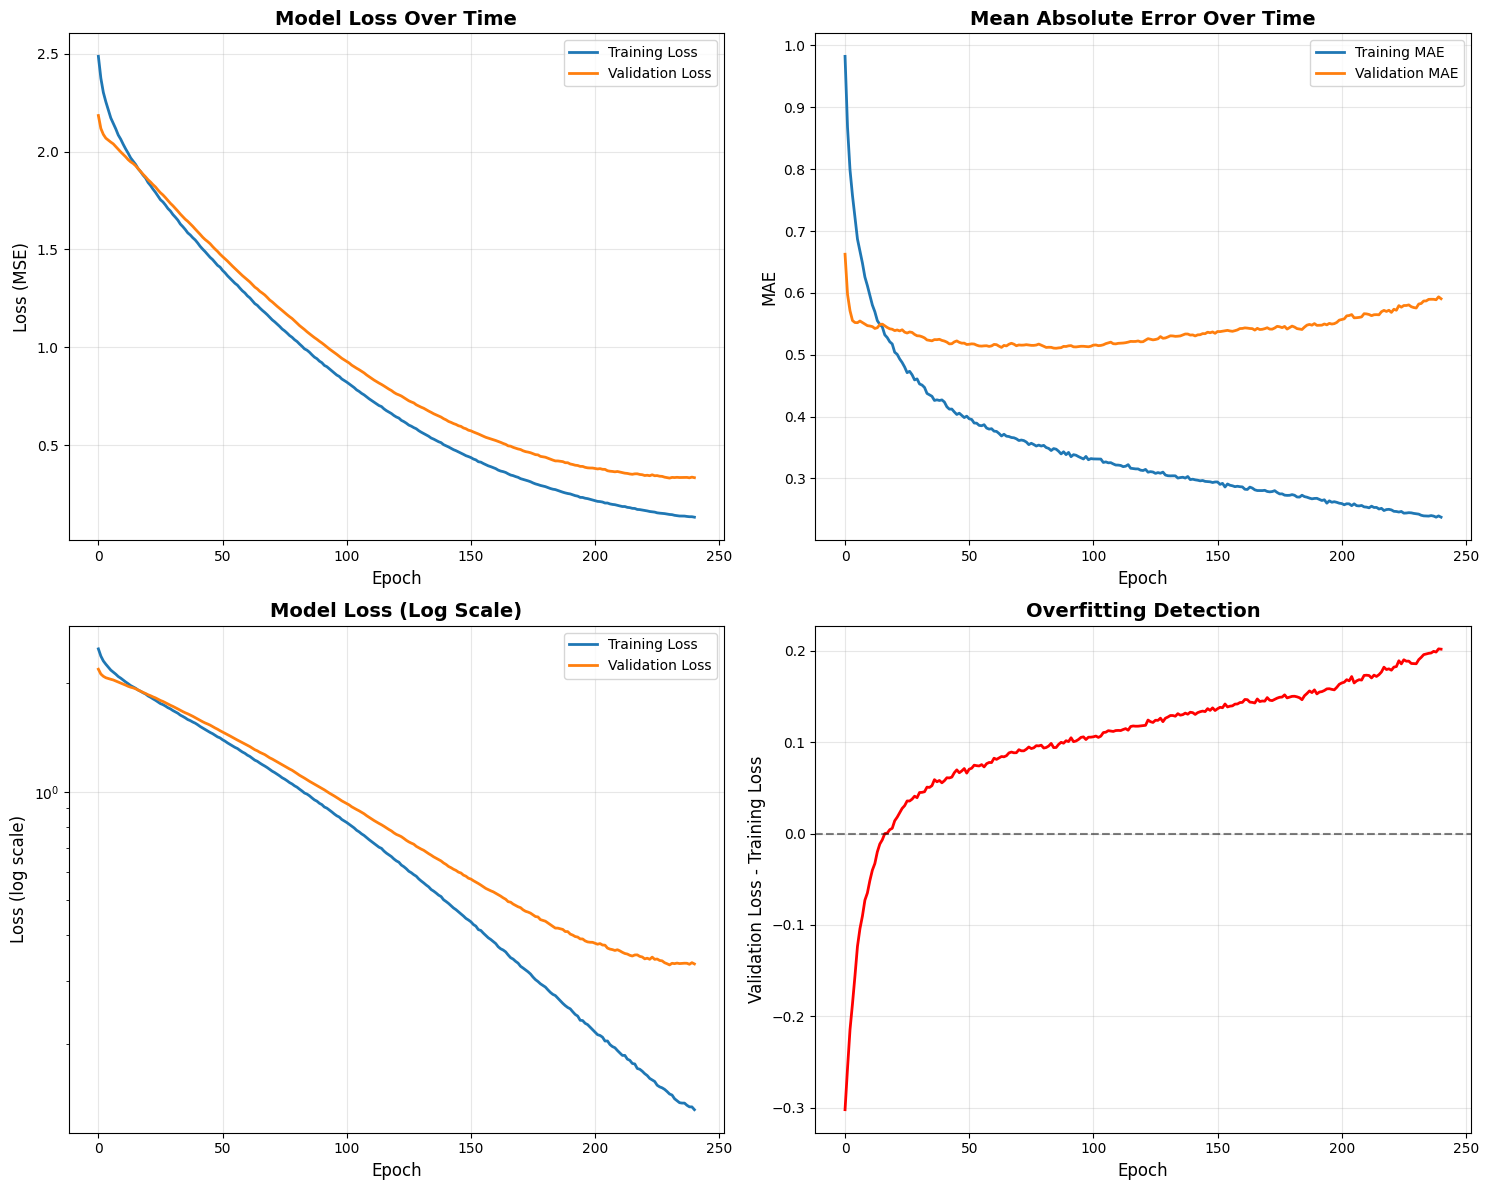


2. Predictions Analysis...


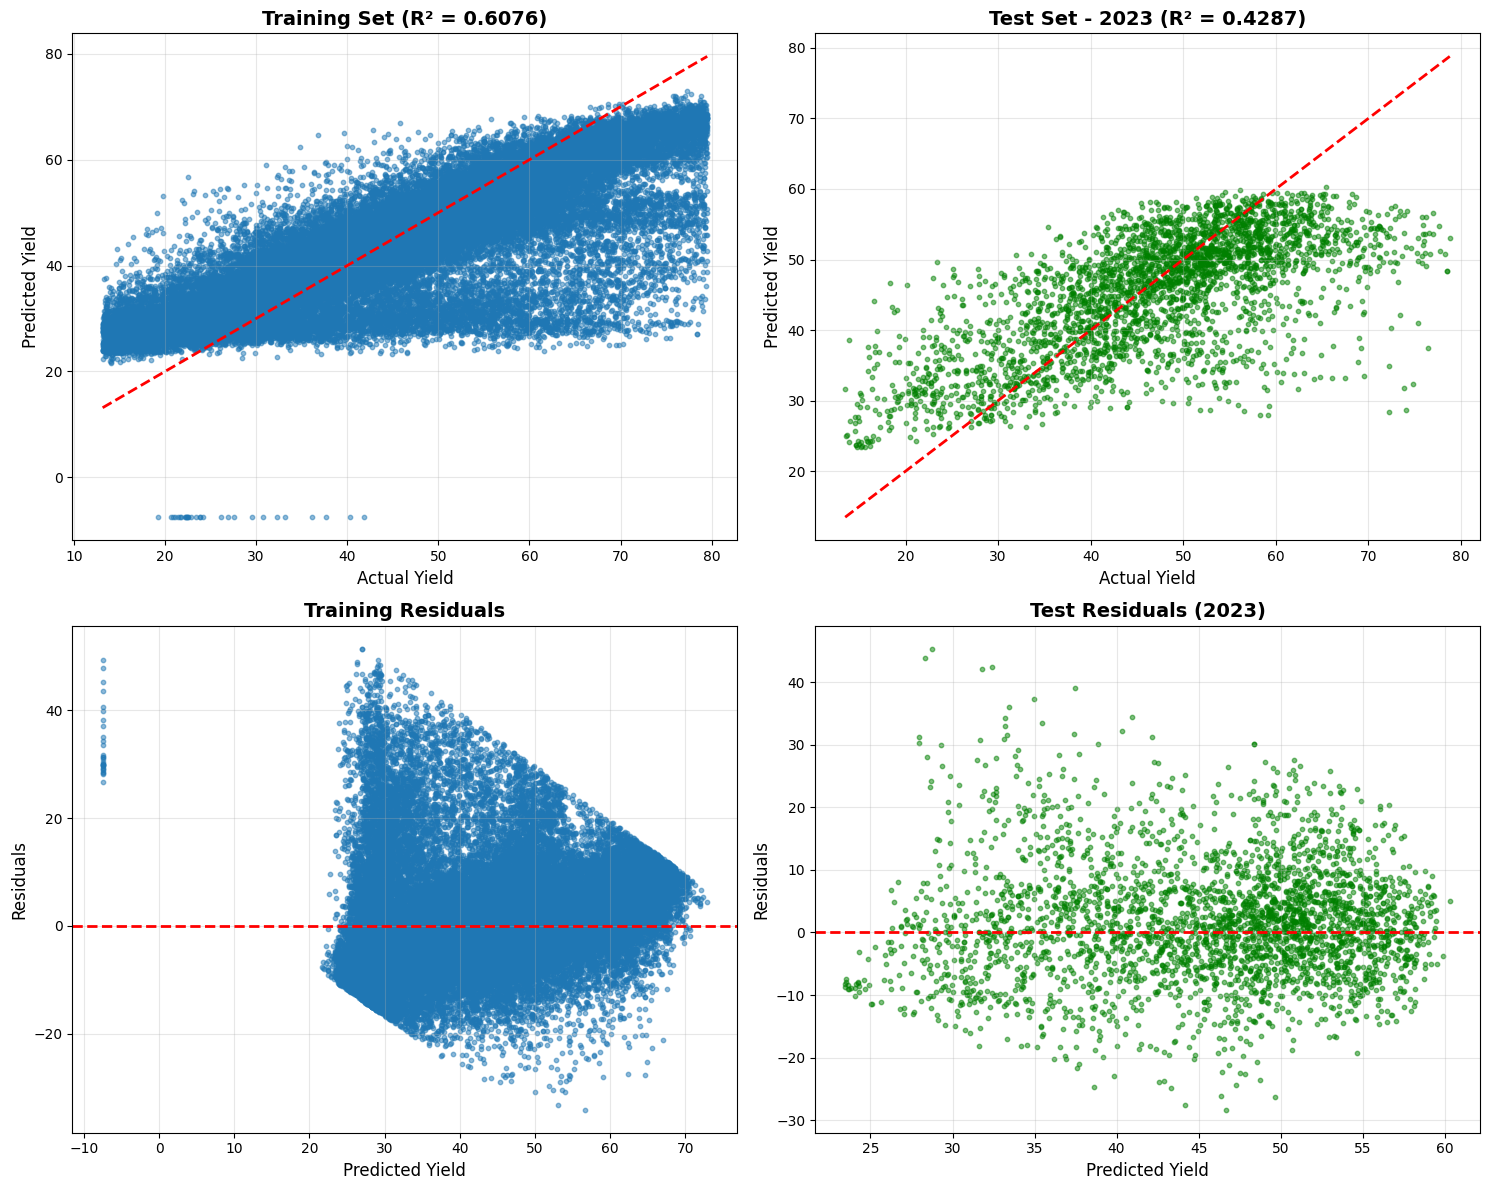


3. Error Distribution...


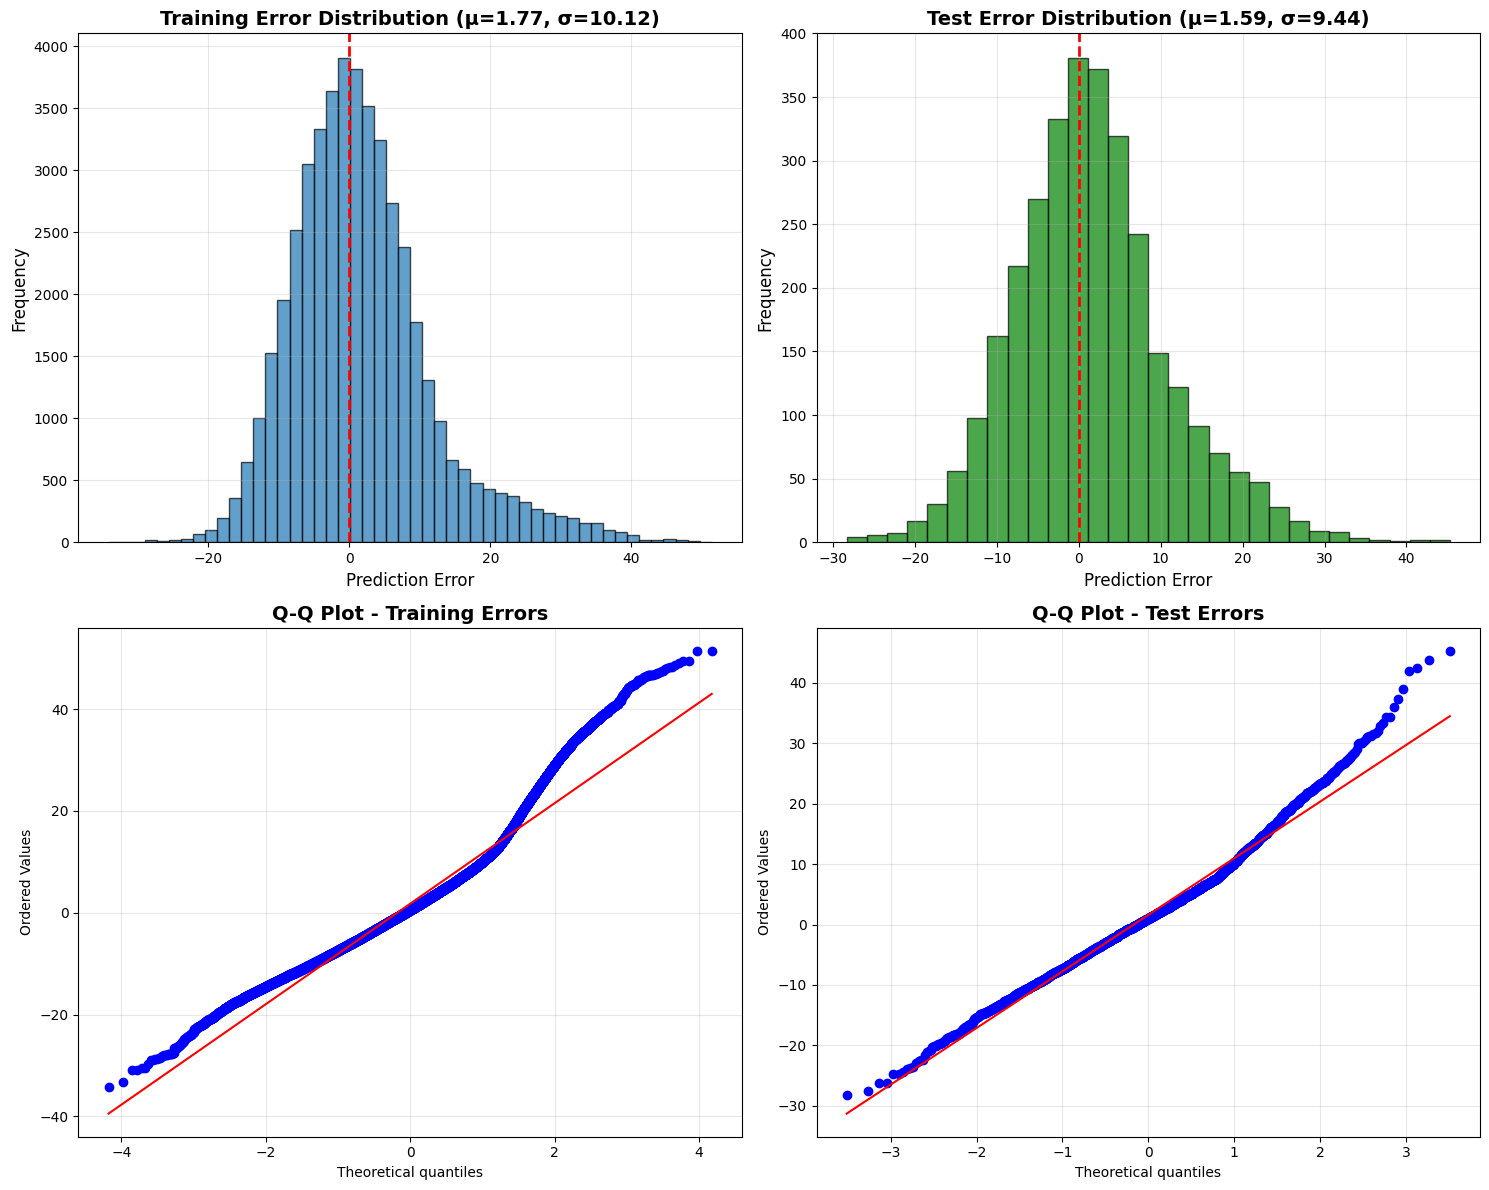


4. Metrics Comparison...


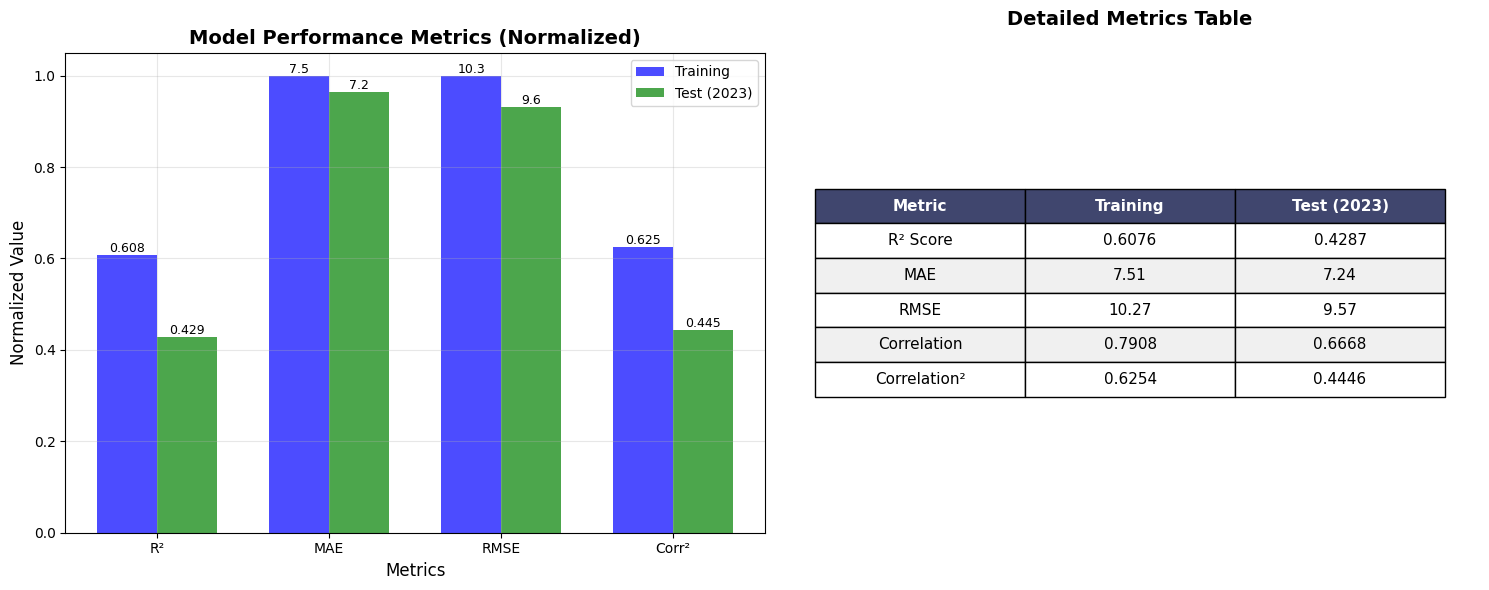


ANALYZING FEATURE IMPORTANCE...


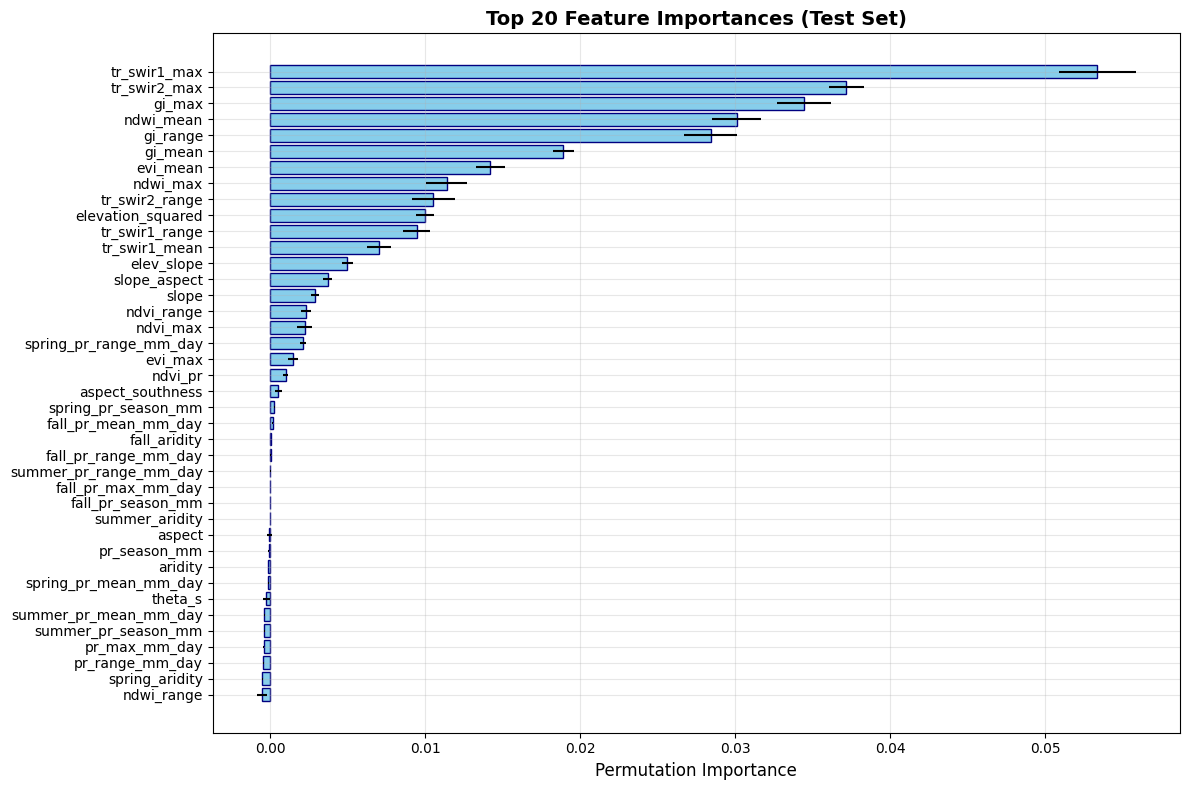


SAVING MODEL...
Model saved as 'final_soybean_yield_model.h5'
Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'

ANALYSIS COMPLETE!


In [27]:
# ===============================================
# Best Results for 2023 on 50k random dataset
# ===============================================
model, metrics, history = main()